In [119]:
import pandas as pd
from sklearn.cluster import KMeans
from transformers import BertTokenizer, BertModel
import torch
torch.cuda.is_available()


True

## Загрузка данных

In [120]:
features_file = r'C:\ML\28_final_task\D_Online_Retail.xlsx'
df = pd.read_excel(features_file)
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         9   
1    536365     71053                  WHITE METAL LANTERN        10   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         9   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         7   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         9   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom  
3 2010-12-01 08:26:00       3.39       17850  United Kingdom  
4 2010-12-01 08:26:00       3.39       17850  United Kingdom

## Подготовка данных для катетеризации товаров и предсказания продаж по категориям

In [151]:
## функция очистки значений
def check_descriptions(value):
    if type(value) == str:
        if (len(value) < 2) or '?' in value:
            return "Прочие"
    return value

In [152]:
df['Description'] = df['Description'].map(lambda x: check_descriptions(x))

#### Пред обработка данных, для исключения пропусков и замены пустых значений

In [153]:
import warnings
warnings.filterwarnings("ignore")

df['Description'].fillna('Прочие', inplace=True)
# df['CustomerID'].fillna(-999999, inplace=True)
df['InvoiceNo'].fillna('без номера', inplace=True)
df['Return'] = df['InvoiceNo'].astype(str).str.startswith('C').astype(int)
df['Description'] = df['Description'].str.strip()

df_without_other = df[df['Description'] != 'Прочие']
unique_descriptions = df_without_other[['Description']].drop_duplicates()
unique_descriptions = unique_descriptions.reset_index(drop=True)
print("DataFrame с уникальными товарами:")

DataFrame с уникальными товарами:


In [154]:
len(unique_descriptions)

4186

## Кластеризация товаров для формирования групп товаров

In [125]:
descriptions = unique_descriptions['Description'].tolist()
unique_descriptions['Description'] = unique_descriptions['Description'].astype(str)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
len(descriptions), device

использование модели `paraphrase-MiniLM-L6-v2`

In [155]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

models = [
    'paraphrase-MiniLM-L6-v2',
    'all-MiniLM-L6-v2',
    'bert-base-uncased',
    'roberta-base',
    'distilbert-base-uncased'
]

k_values = list(range(2, 11))

best_score = -1
best_model_name = None
best_k = None
best_clusters = None
best_embeddings = None

for model_name in models:
    print(f"Using model: {model_name}")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SentenceTransformer(model_name, device=device)
    print('device', device)
    embeddings = model.encode(descriptions, show_progress_bar=True, device=device)
    
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(embeddings)
    
    tsne = TSNE(n_components=2, random_state=0)
    reduced_embeddings = tsne.fit_transform(normalized_embeddings)
    
    for k in k_values:
        print(f"Testing KMeans with k={k}")
        kmeans = KMeans(n_clusters=k, random_state=0)
        clusters = kmeans.fit_predict(normalized_embeddings)

        silhouette_avg = silhouette_score(normalized_embeddings, clusters, metric='cosine') # cosine
        calinski_harabasz = calinski_harabasz_score(normalized_embeddings, clusters)
        davies_bouldin = davies_bouldin_score(normalized_embeddings, clusters)

        print(f'K={k}, Silhouette Score: {silhouette_avg}, Calinski-Harabasz Score: {calinski_harabasz}, Davies-Bouldin Score: {davies_bouldin}')
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_model_name = model_name
            best_k = k
            best_clusters = clusters
            best_embeddings = reduced_embeddings



Using model: paraphrase-MiniLM-L6-v2
device cuda


Batches: 100%|██████████| 131/131 [00:00<00:00, 137.04it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.054031044244766235, Calinski-Harabasz Score: 119.6544824863822, Davies-Bouldin Score: 5.870671071959713
Testing KMeans with k=3
K=3, Silhouette Score: 0.05936692655086517, Calinski-Harabasz Score: 115.73255798665555, Davies-Bouldin Score: 5.029848533909589
Testing KMeans with k=4
K=4, Silhouette Score: 0.060654934495687485, Calinski-Harabasz Score: 105.4338364916001, Davies-Bouldin Score: 4.683574448740237
Testing KMeans with k=5
K=5, Silhouette Score: 0.06401477754116058, Calinski-Harabasz Score: 96.67594302815799, Davies-Bouldin Score: 4.459126324921147
Testing KMeans with k=6
K=6, Silhouette Score: 0.06761325150728226, Calinski-Harabasz Score: 93.01433133234406, Davies-Bouldin Score: 4.206347191583515
Testing KMeans with k=7
K=7, Silhouette Score: 0.07458978146314621, Calinski-Harabasz Score: 89.4136914563854, Davies-Bouldin Score: 3.991056320856028
Testing KMeans with k=8
K=8, Silhouette Score: 0.07608991861343384, Calinski-Harabasz 

Batches: 100%|██████████| 131/131 [00:00<00:00, 143.19it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05198387801647186, Calinski-Harabasz Score: 112.74820401811033, Davies-Bouldin Score: 5.739874082405795
Testing KMeans with k=3
K=3, Silhouette Score: 0.04839610308408737, Calinski-Harabasz Score: 94.53377752773414, Davies-Bouldin Score: 5.786555221596207
Testing KMeans with k=4
K=4, Silhouette Score: 0.051954057067632675, Calinski-Harabasz Score: 85.63584196019404, Davies-Bouldin Score: 5.389660224162474
Testing KMeans with k=5
K=5, Silhouette Score: 0.053254082798957825, Calinski-Harabasz Score: 79.17861703074657, Davies-Bouldin Score: 5.166033710056825
Testing KMeans with k=6
K=6, Silhouette Score: 0.059810493141412735, Calinski-Harabasz Score: 76.1528554588564, Davies-Bouldin Score: 4.824879976595076
Testing KMeans with k=7
K=7, Silhouette Score: 0.06387324631214142, Calinski-Harabasz Score: 72.08395825913587, Davies-Bouldin Score: 4.711581867949552
Testing KMeans with k=8
K=8, Silhouette Score: 0.06687717884778976, Calinski-Harabasz

No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.


K=10, Silhouette Score: 0.06869956105947495, Calinski-Harabasz Score: 63.0594552476516, Davies-Bouldin Score: 4.2974364807741186
Using model: bert-base-uncased


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

device cuda


Batches: 100%|██████████| 131/131 [00:02<00:00, 64.11it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.08112740516662598, Calinski-Harabasz Score: 188.81613485015933, Davies-Bouldin Score: 4.665770737732477
Testing KMeans with k=3
K=3, Silhouette Score: 0.07301562279462814, Calinski-Harabasz Score: 154.03471766222052, Davies-Bouldin Score: 4.583339511036368
Testing KMeans with k=4
K=4, Silhouette Score: 0.06834179162979126, Calinski-Harabasz Score: 127.97330875122815, Davies-Bouldin Score: 4.501889491581732
Testing KMeans with k=5
K=5, Silhouette Score: 0.07067649066448212, Calinski-Harabasz Score: 115.32021826384728, Davies-Bouldin Score: 4.290506920739949
Testing KMeans with k=6
K=6, Silhouette Score: 0.06715759634971619, Calinski-Harabasz Score: 101.93975891554413, Davies-Bouldin Score: 4.223181507156182
Testing KMeans with k=7
K=7, Silhouette Score: 0.05651898309588432, Calinski-Harabasz Score: 93.11091532301057, Davies-Bouldin Score: 4.304449645626762
Testing KMeans with k=8
K=8, Silhouette Score: 0.06238424405455589, Calinski-Haraba

No sentence-transformers model found with name roberta-base. Creating a new one with mean pooling.


K=10, Silhouette Score: 0.058419644832611084, Calinski-Harabasz Score: 75.81808686569764, Davies-Bouldin Score: 4.181168093000723
Using model: roberta-base


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device cuda


Batches: 100%|██████████| 131/131 [00:02<00:00, 51.78it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.06121441349387169, Calinski-Harabasz Score: 139.72589727877977, Davies-Bouldin Score: 5.394788283082473
Testing KMeans with k=3
K=3, Silhouette Score: 0.04503694549202919, Calinski-Harabasz Score: 146.839110900055, Davies-Bouldin Score: 4.384003629715679
Testing KMeans with k=4
K=4, Silhouette Score: 0.05106807500123978, Calinski-Harabasz Score: 126.28294888459936, Davies-Bouldin Score: 4.523683858750046
Testing KMeans with k=5
K=5, Silhouette Score: 0.052409376949071884, Calinski-Harabasz Score: 112.15976800440096, Davies-Bouldin Score: 4.466785752115174
Testing KMeans with k=6
K=6, Silhouette Score: 0.05639660730957985, Calinski-Harabasz Score: 106.52957384329233, Davies-Bouldin Score: 4.196755685341963
Testing KMeans with k=7
K=7, Silhouette Score: 0.05708536133170128, Calinski-Harabasz Score: 95.7566473998984, Davies-Bouldin Score: 4.3381454243008095
Testing KMeans with k=8
K=8, Silhouette Score: 0.060547836124897, Calinski-Harabasz 

No sentence-transformers model found with name distilbert-base-uncased. Creating a new one with mean pooling.


K=10, Silhouette Score: 0.06461387872695923, Calinski-Harabasz Score: 77.27479706013716, Davies-Bouldin Score: 4.190472696292419
Using model: distilbert-base-uncased
device cuda


Batches: 100%|██████████| 131/131 [00:01<00:00, 119.22it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.0709916278719902, Calinski-Harabasz Score: 160.86821425028845, Davies-Bouldin Score: 4.969118591891541
Testing KMeans with k=3
K=3, Silhouette Score: 0.07153258472681046, Calinski-Harabasz Score: 146.6010888651486, Davies-Bouldin Score: 4.37897456440366
Testing KMeans with k=4
K=4, Silhouette Score: 0.06994958221912384, Calinski-Harabasz Score: 131.20304581795162, Davies-Bouldin Score: 4.069884280899016
Testing KMeans with k=5
K=5, Silhouette Score: 0.07466502487659454, Calinski-Harabasz Score: 123.5464017636579, Davies-Bouldin Score: 3.908310600214341
Testing KMeans with k=6
K=6, Silhouette Score: 0.07346051931381226, Calinski-Harabasz Score: 110.15268225917713, Davies-Bouldin Score: 3.845830022484814
Testing KMeans with k=7
K=7, Silhouette Score: 0.07538436353206635, Calinski-Harabasz Score: 103.59121697577486, Davies-Bouldin Score: 3.7593439104492004
Testing KMeans with k=8
K=8, Silhouette Score: 0.062245726585388184, Calinski-Harabas

In [156]:
print(f'Best model: {best_model_name}')
print(f'Best number of clusters (K): {best_k}')
print(f'Best Silhouette Score: {best_score}')


Best model: paraphrase-MiniLM-L6-v2
Best number of clusters (K): 9
Best Silhouette Score: 0.08163392543792725


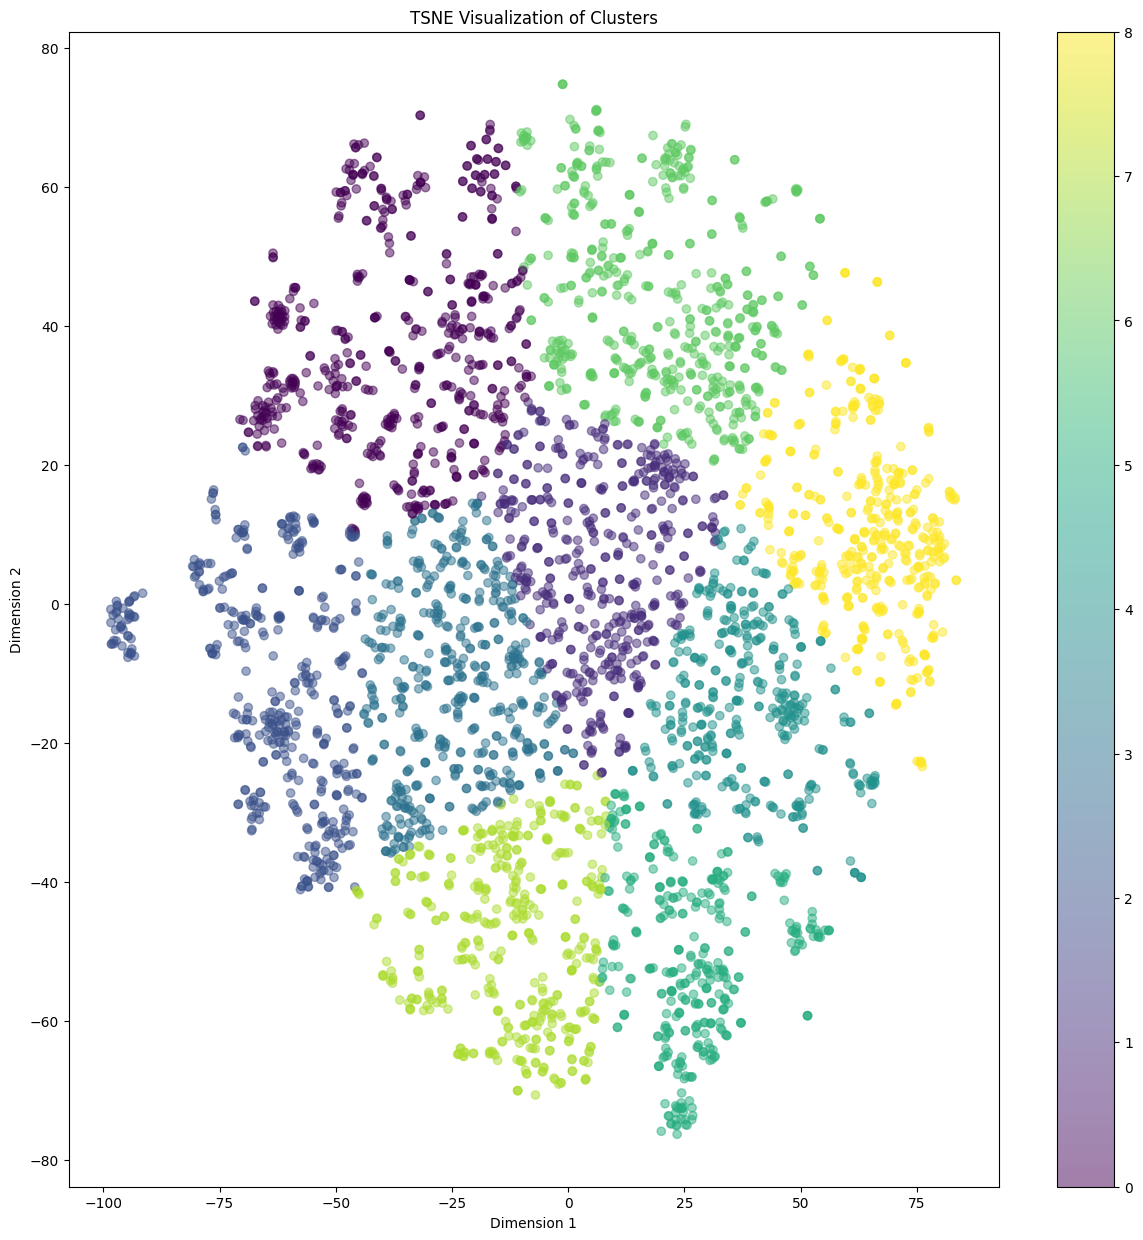

In [157]:

kmeans = KMeans(n_clusters=best_k, random_state=0)
clusters_4 = kmeans.fit_predict(best_embeddings)

unique_descriptions['clusters_4'] = clusters_4

plt.figure(figsize=(15, 15))
scatter = plt.scatter(best_embeddings[:, 0], best_embeddings[:, 1], c=clusters_4, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('TSNE Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [158]:
cluster_distribution = unique_descriptions['clusters_4'].value_counts()
print("Cluster distribution:")
cluster_distribution

Cluster distribution:


clusters_4
0    573
6    547
1    494
3    491
8    449
7    442
2    441
4    388
5    361
Name: count, dtype: int64

In [175]:
for cluster_num in set(clusters_4):
    if cluster_num != -1:
        cluster_df = unique_descriptions[unique_descriptions['clusters_4'] == cluster_num]['Description'].value_counts()
        top_items = cluster_df.head(10)
        print(f"Cluster {cluster_num}:")
        print(top_items.index.tolist())
        # print("\n")

Cluster 0:
["POPPY'S PLAYHOUSE BEDROOM", 'S/2 BEACH HUT TREASURE CHESTS', 'Damaged', 'BEACH HUT MIRROR', 'TUMBLER BAROQUE', 'mystery! Only ever imported 1800', 'TUMBLER NEW ENGLAND', 'SWEETHEART KEY CABINET', 'damaged', 'cracked']
Cluster 1:
['GLASS STAR FROSTED T-LIGHT HOLDER', 'RED POLKADOT BEAKER', 'SET/3 RABBITS FLOWER SKIPPPING ROPE', 'PINK BOUDOIR T-LIGHT HOLDER', 'SET/3 POLKADOT STACKING TINS', 'NEW BAROQUE JEWELLERY BOX', 'CANDY SPOT HAND BAG', 'SILVER T-LIGHT SETTING', 'SKULLS STORAGE BOX LARGE', 'CERAMIC BOWL WITH LOVE HEART DESIGN']
Cluster 2:
['ALARM CLOCK BAKELIKE PINK', 'SET OF 2 CERAMIC CHRISTMAS TREES', 'MINT DINER WALL CLOCK', 'RED REFECTORY CLOCK', 'IVORY REFECTORY CLOCK', 'SET OF 4 SANTA PLACE SETTINGS', 'SKETCHBOOK MAGNETIC SHOPPING LIST', 'CHRISTMAS TREE HANGING GOLD', 'CHRISTMAS TREE HANGING SILVER', 'PANTRY MAGNETIC  SHOPPING LIST']
Cluster 3:
['SET 7 BABUSHKA NESTING BOXES', 'JIGSAW TREE WITH WATERING CAN', 'RED RETROSPOT SMALL MILK JUG', 'CAKE STAND 3 TIER MAGI

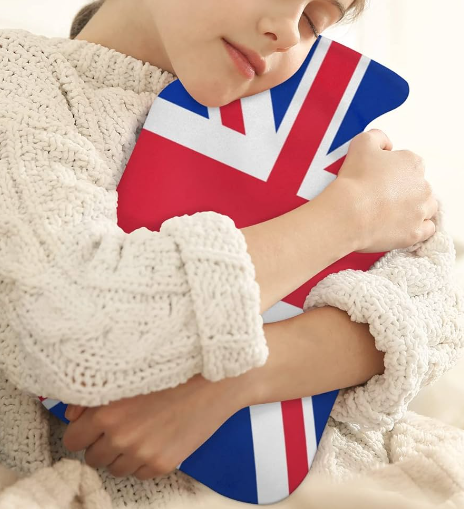 *Подпись к фото 1*  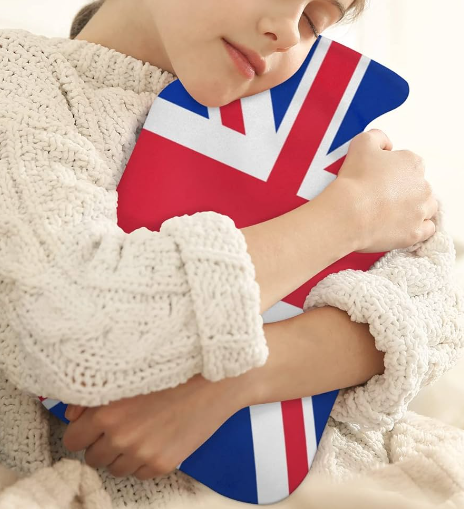 *Подпись к фото 1*


In [16]:
with open('clusters_4_top_20_per_cluster.txt', 'w', encoding='utf-8') as file:
    for cluster_num in set(clusters_4):
        if cluster_num != -1:
            cluster_df = unique_descriptions[unique_descriptions['clusters_4'] == cluster_num]['Description'].value_counts().head(30)
            file.write(f"Cluster {cluster_num}: ")
            file.write('; '.join(cluster_df.index.tolist())) 
            file.write("\n")

In [132]:
unique_descriptions

Description  clusters_4
0      WHITE HANGING HEART T-LIGHT HOLDER           6
1                     WHITE METAL LANTERN           5
2          CREAM CUPID HEARTS COAT HANGER           6
3     KNITTED UNION FLAG HOT WATER BOTTLE           6
4          RED WOOLLY HOTTIE WHITE HEART.           6
...                                   ...         ...
4181                            wet boxes           0
4182                             mixed up           0
4183                                 lost           0
4184   CREAM HANGING HEART T-LIGHT HOLDER           6
4185          PAPER CRAFT , LITTLE BIRDIE           7

[4186 rows x 2 columns]

In [181]:
category_name = {
    0: '1. Стилизованные вещи интерьера с уникальным дизайном',
    1: '2. Стеклянные и керамические аксессуары (оформление интерьера)',
    2: '3. Часы и рождественские украшения',
    3: '4. Кухонные аксессуары и посуда',
    4: '5. Ювелирные изделия',
    5: '6. Свечи и освещение',
    6: '7. Декор для дома',
    7: '8. Праздничные украшения',
    8: '9. Браслеты',
}

In [182]:
unique_descriptions['category_name'] = unique_descriptions.clusters_4.apply(lambda x : category_name.get(x, 'other'))

In [183]:
from googletrans import Translator
translator = Translator()

# Функция для перевода текста
def translate_text(text):
    try:
        return translator.translate(text, dest='ru').text  # Замените 'ru' на нужный язык
    except Exception as e:
        print(f"Ошибка перевода: {e}")
        return text

In [184]:
unique_descriptions[:15]

Description  clusters_4  \
0    WHITE HANGING HEART T-LIGHT HOLDER           6   
1                   WHITE METAL LANTERN           5   
2        CREAM CUPID HEARTS COAT HANGER           6   
3   KNITTED UNION FLAG HOT WATER BOTTLE           6   
4        RED WOOLLY HOTTIE WHITE HEART.           6   
5          SET 7 BABUSHKA NESTING BOXES           3   
6     GLASS STAR FROSTED T-LIGHT HOLDER           1   
7                HAND WARMER UNION JACK           1   
8             HAND WARMER RED POLKA DOT           7   
9         ASSORTED COLOUR BIRD ORNAMENT           7   
10            POPPY'S PLAYHOUSE BEDROOM           0   
11            POPPY'S PLAYHOUSE KITCHEN           0   
12    FELTCRAFT PRINCESS CHARLOTTE DOLL           4   
13               IVORY KNITTED MUG COSY           7   
14   BOX OF 6 ASSORTED COLOUR TEASPOONS           3   

                                        category_name  
0                                   7. Декор для дома  
1                                6. Свечи и освещение  
2                                   7. Декор для дома  
3                                   7. Декор для дома  
4                                   7. Декор для дома  
5                     4. Кухонные аксессуары и посуда  
6   2. Стеклянные и керамические аксессуары (оформ...  
7   2. Стеклянные и керамические аксессуары (оформ...  
8                            8. Праздничные украшения  
9                            8. Праздничные украшения  
10  1. Стилизованные вещи интерьера с уникальным д...  
11  1. Стилизованные вещи интерьера с уникальным д...  
12                               5. Ювелирные изделия  
13                           8. Праздничные украшения  
14                    4. Кухонные аксессуары и посуда

перевод 50 товарных позиций для каждой категории для оценки семантического сходства товарных позиций в категориях (25-30% от общего кол. в каждой категории)

## Перевод названий товаров на Русский язык

In [27]:
# перевод названий на русский язык
# unique_descriptions['translate'] = unique_descriptions.Description.map(lambda x : translate_text(x))

In [185]:
unique_descriptions

Description  clusters_4  \
0      WHITE HANGING HEART T-LIGHT HOLDER           6   
1                     WHITE METAL LANTERN           5   
2          CREAM CUPID HEARTS COAT HANGER           6   
3     KNITTED UNION FLAG HOT WATER BOTTLE           6   
4          RED WOOLLY HOTTIE WHITE HEART.           6   
...                                   ...         ...   
4181                            wet boxes           0   
4182                             mixed up           0   
4183                                 lost           0   
4184   CREAM HANGING HEART T-LIGHT HOLDER           6   
4185          PAPER CRAFT , LITTLE BIRDIE           7   

                                          category_name  
0                                     7. Декор для дома  
1                                  6. Свечи и освещение  
2                                     7. Декор для дома  
3                                     7. Декор для дома  
4                                     7. Декор для дома  
...                                                 ...  
4181  1. Стилизованные вещи интерьера с уникальным д...  
4182  1. Стилизованные вещи интерьера с уникальным д...  
4183  1. Стилизованные вещи интерьера с уникальным д...  
4184                                  7. Декор для дома  
4185                           8. Праздничные украшения  

[4186 rows x 3 columns]

In [ ]:
# запись данных в эксель
# unique_descriptions.to_excel('unique_descriptions_category.xlsx')

In [186]:
df_with_category = df.merge(unique_descriptions, how='left')

In [187]:
df_with_category['category_name'].fillna('11. Прочие', inplace=True)

In [188]:
df_with_category['clusters_4'].fillna('11', inplace=True)

In [189]:
df_with_category

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         9   
1         536365     71053                  WHITE METAL LANTERN        10   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         9   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         7   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         9   
...          ...       ...                                  ...       ...   
966418    581019    84251G     GREETING CARD, OVERCROWDED POOL.         6   
966419    581439    17084P                DRAGONS BLOOD INCENSE         9   
966420    580744     22899          CHILDREN'S APRON DOLLY GIRL        23   
966421    580730     21288      STRIPEY CHOCOLATE NESTING BOXES         6   
966422    580730     21137             BLACK RECORD COVER FRAME         8   

               InvoiceDate  UnitPrice  CustomerID         Country  Return  \
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       0   
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       0   
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
...                    ...        ...         ...             ...     ...   
966418 2012-12-07 10:11:00       0.19       14794  United Kingdom       0   
966419 2012-12-08 16:30:00       0.42     -999999  United Kingdom       0   
966420 2012-12-06 09:31:00       1.85       13694  United Kingdom       0   
966421 2012-12-05 17:28:00       3.29     -999999  United Kingdom       0   
966422 2012-12-05 17:28:00       4.13     -999999  United Kingdom       0   

       clusters_4                       category_name  
0             6.0                   7. Декор для дома  
1             5.0                6. Свечи и освещение  
2             6.0                   7. Декор для дома  
3             6.0                   7. Декор для дома  
4             6.0                   7. Декор для дома  
...           ...                                 ...  
966418        2.0  3. Часы и рождественские украшения  
966419        5.0                6. Свечи и освещение  
966420        7.0            8. Праздничные украшения  
966421        7.0            8. Праздничные украшения  
966422        6.0                   7. Декор для дома  

[966423 rows x 11 columns]

In [190]:
# Добавление столбца с номером недели года и месяца
df_with_category['Week'] = df_with_category['InvoiceDate'].dt.isocalendar().week
df_with_category['Month'] = df_with_category['InvoiceDate'].dt.month
df_with_category['Year'] = df_with_category['InvoiceDate'].dt.year

In [191]:
df_with_category

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         9   
1         536365     71053                  WHITE METAL LANTERN        10   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         9   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         7   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         9   
...          ...       ...                                  ...       ...   
966418    581019    84251G     GREETING CARD, OVERCROWDED POOL.         6   
966419    581439    17084P                DRAGONS BLOOD INCENSE         9   
966420    580744     22899          CHILDREN'S APRON DOLLY GIRL        23   
966421    580730     21288      STRIPEY CHOCOLATE NESTING BOXES         6   
966422    580730     21137             BLACK RECORD COVER FRAME         8   

               InvoiceDate  UnitPrice  CustomerID         Country  Return  \
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       0   
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       0   
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
...                    ...        ...         ...             ...     ...   
966418 2012-12-07 10:11:00       0.19       14794  United Kingdom       0   
966419 2012-12-08 16:30:00       0.42     -999999  United Kingdom       0   
966420 2012-12-06 09:31:00       1.85       13694  United Kingdom       0   
966421 2012-12-05 17:28:00       3.29     -999999  United Kingdom       0   
966422 2012-12-05 17:28:00       4.13     -999999  United Kingdom       0   

       clusters_4                       category_name  Week  Month  Year  
0             6.0                   7. Декор для дома    48     12  2010  
1             5.0                6. Свечи и освещение    48     12  2010  
2             6.0                   7. Декор для дома    48     12  2010  
3             6.0                   7. Декор для дома    48     12  2010  
4             6.0                   7. Декор для дома    48     12  2010  
...           ...                                 ...   ...    ...   ...  
966418        2.0  3. Часы и рождественские украшения    49     12  2012  
966419        5.0                6. Свечи и освещение    49     12  2012  
966420        7.0            8. Праздничные украшения    49     12  2012  
966421        7.0            8. Праздничные украшения    49     12  2012  
966422        6.0                   7. Декор для дома    49     12  2012  

[966423 rows x 14 columns]

## Аналитика временных рядов продаж категорий товаров

Гипотезы сезонности:

+ Категория 1: Декор для дома и аксессуары: Рост продаж в весенний и осенний сезоны (апрель-май и сентябрь-октябрь), снижение летом и зимой.
+ Категория 2: Ювелирные изделия и модные аксессуары: Рост продаж перед Днем Святого Валентина (неделя 7) и в декабре (новогодние праздники).
+ Категория 3: Посуда и кухонные принадлежности: Пик продаж перед праздниками (недели 48-52), снижение летом (недели 26-34).
+ Категория 4: Декоративные предметы и подарки: Рост в декабре (новогодние праздники) и весной (недели 12-16, предположительно Пасха).
+ Категория 5: Товары для праздников и торжеств: Резкий рост продаж в декабре, снижение в начале года.
+ Категория 6: Детские игрушки и принадлежности: Пик продаж в декабре, снижение в январе.
+ Категория 7: Праздничный декор и свечи: Пик продаж в декабре (недели 48-52), снижение в январе.
+ Категория 8: Часы и органайзеры: Стабильный спрос, без выраженной сезонности, добавляем только шум.
+ Категория 9: Сумки и текстиль: Падение продаж летом (недели 26-34), рост в декабре.
+ Категория 10: Игрушки и предметы для детей: Пик продаж в декабре, снижение в январе.
+ Категория 11: Прочие: Здесь будет просто добавлен случайный шум.

In [192]:
df_with_category

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         9   
1         536365     71053                  WHITE METAL LANTERN        10   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         9   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         7   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         9   
...          ...       ...                                  ...       ...   
966418    581019    84251G     GREETING CARD, OVERCROWDED POOL.         6   
966419    581439    17084P                DRAGONS BLOOD INCENSE         9   
966420    580744     22899          CHILDREN'S APRON DOLLY GIRL        23   
966421    580730     21288      STRIPEY CHOCOLATE NESTING BOXES         6   
966422    580730     21137             BLACK RECORD COVER FRAME         8   

               InvoiceDate  UnitPrice  CustomerID         Country  Return  \
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       0   
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       0   
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
...                    ...        ...         ...             ...     ...   
966418 2012-12-07 10:11:00       0.19       14794  United Kingdom       0   
966419 2012-12-08 16:30:00       0.42     -999999  United Kingdom       0   
966420 2012-12-06 09:31:00       1.85       13694  United Kingdom       0   
966421 2012-12-05 17:28:00       3.29     -999999  United Kingdom       0   
966422 2012-12-05 17:28:00       4.13     -999999  United Kingdom       0   

       clusters_4                       category_name  Week  Month  Year  
0             6.0                   7. Декор для дома    48     12  2010  
1             5.0                6. Свечи и освещение    48     12  2010  
2             6.0                   7. Декор для дома    48     12  2010  
3             6.0                   7. Декор для дома    48     12  2010  
4             6.0                   7. Декор для дома    48     12  2010  
...           ...                                 ...   ...    ...   ...  
966418        2.0  3. Часы и рождественские украшения    49     12  2012  
966419        5.0                6. Свечи и освещение    49     12  2012  
966420        7.0            8. Праздничные украшения    49     12  2012  
966421        7.0            8. Праздничные украшения    49     12  2012  
966422        6.0                   7. Декор для дома    49     12  2012  

[966423 rows x 14 columns]

In [100]:
import pandas as pd
import numpy as np

# Копируем данные за 2011 год
data_2011 = df_with_category[df_with_category['Year'] == 2011].copy()

# Создаем данные за 2012 год, изменяя год на 2012
data_2012 = data_2011.copy()
data_2012['Year'] = 2012

# Изменяем даты на год 2012, сохраняя ту же неделю
data_2012['InvoiceDate'] = data_2012['InvoiceDate'].apply(lambda d: d.replace(year=2012))

# Функция для добавления сезонных изменений с ярким трендом
def add_seasonality(row):
    week = row['Week']
    category = row['category_name']
    base_quantity = row['Quantity']
    
    seasonal_multiplier = 1.0
    
    # Сезонные коэффициенты для каждой категории
    seasonal_factors = {
        '1. Декор для дома и аксессуары': [(13, 20, 1.3, 1.5), (36, 44, 1.2, 1.4), (26, 34, 0.7, 0.8), (1, 10, 0.6, 0.7)],
        '2. Ювелирные изделия и модные аксессуары': [(6, 8, 1.6, 2.0), (42, 46, 1.5, 2.0)],
        '3. Посуда и кухонные принадлежности': [(48, 52, 1.5, 2.0), (26, 34, 0.7, 0.8)],
        '4. Декоративные предметы и подарки': [(12, 16, 1.4, 1.8), (48, 52, 1.4, 1.8)],
        '5. Товары для праздников и торжеств': [(46, 52, 2.0, 3.0), (2, 4, 0.5, 0.7)],
        '6. Детские игрушки и принадлежности': [(42, 52, 2.0, 3.5), (3, 6, 0.5, 0.6)],
        '7. Праздничный декор и свечи': [(48, 52, 1.8, 2.5), (1, 6, 0.5, 0.7)],
        '9. Сумки и текстиль': [(48, 52, 1.4, 1.8), (26, 34, 0.7, 0.8)],
        '10. Игрушки и предметы для детей': [(48, 52, 2.0, 3.0), (1, 6, 0.5, 0.7)]
    }
    
    if category in seasonal_factors:
        for start, end, low, high in seasonal_factors[category]:
            if start <= week <= end:
                seasonal_multiplier = np.random.uniform(low, high)
                break
    
    return int(base_quantity * seasonal_multiplier)  # Округляем до целого числа

# Применяем функцию для изменения данных за 2012 год
data_2012['Quantity'] = data_2012.apply(add_seasonality, axis=1)

# Функция для случайного изменения количества продаж
def adjust_quantity(row):
    return max(0, int(row['Quantity'] * np.random.uniform(0.8, 1.2)))  # Убедимся, что количество не отрицательно

data_2012['Quantity'] = data_2012.apply(adjust_quantity, axis=1)

# Функция для добавления возвратов
def add_returns(df, return_fraction=0.1):
    df_with_returns = df.copy()
    df_with_returns['Returns'] = 0  # Инициализация столбца для возвратов
    for category in df['category_name'].unique():
        category_mask = df['category_name'] == category
        num_returns = int(np.ceil(return_fraction * df[category_mask].shape[0]))
        return_indices = df[category_mask].sample(n=num_returns, random_state=1).index
        df_with_returns.loc[return_indices, 'Returns'] = (df_with_returns.loc[return_indices, 'Quantity'] * 
                                                          np.random.uniform(0.05, 0.1)).astype(int)
    return df_with_returns

# Применяем возвраты к данным за 2012 год
data_2012 = add_returns(data_2012)

# Функция для случайного удаления строк
def random_row_deletion(df, fraction):
    return df.sample(frac=(1 - fraction), random_state=1)

# Применяем случайное удаление строк
data_2012 = random_row_deletion(data_2012, fraction=0.15)  # Удаляем 15% данных

# Функция для коррекции выбросов
def correct_outliers(df, categories, weeks, factor=0.5):
    for category in categories:
        for week in weeks:
            mask = (df['category_name'] == category) & (df['Week'] == week)
            if not df[mask].empty:
                mean_value = df[~mask]['Quantity'].mean()
                df.loc[mask, 'Quantity'] = df.loc[mask, 'Quantity'].apply(lambda x: min(x, mean_value * factor))
    return df

# Определяем категории и недели с выбросами
outlier_categories = ['10. Игрушки и предметы для детей', '7. Праздничный декор и свечи', '6. Детские игрушки и принадлежности', '5. Товары для праздников и торжеств']
outlier_weeks = [48, 49]

# Применяем коррекцию выбросов
data_2012 = correct_outliers(data_2012, outlier_categories, outlier_weeks)

# Коррекция для категории '6. Детские игрушки и принадлежности' в начале года
def smooth_dramatic_increase(df, category, weeks, threshold=2.0):
    for week in weeks:
        mask = (df['category_name'] == category) & (df['Week'] == week)
        if not df[mask].empty:
            mean_value = df.loc[~(df['Week'] == week), 'Quantity'].mean()
            df.loc[mask, 'Quantity'] = df.loc[mask, 'Quantity'].apply(lambda x: min(x, mean_value * threshold))
    return df

data_2012 = smooth_dramatic_increase(data_2012, '6. Детские игрушки и принадлежности', [1, 2], threshold=1.5)

# Объединяем данные за 2010, 2011 и 2012 годы
data_all_years = pd.concat([df_with_category[df_with_category['Year'] == 2010], data_2011, data_2012])

# Сбросим количество до средних значений по годам, чтобы сбалансировать данные
mean_quantities = data_all_years.groupby('Year')['Quantity'].mean()
data_all_years['Quantity'] = data_all_years.apply(
    lambda row: row['Quantity'] * mean_quantities[2011] / mean_quantities[row['Year']],
    axis=1
)

# Добавляем случайный шум к данным для повышения реалистичности
def add_random_noise(row):
    return int(row['Quantity'] * np.random.uniform(0.95, 1.05))

data_all_years['Quantity'] = data_all_years.apply(add_random_noise, axis=1)

# Удаление отрицательных значений, если они остались
data_all_years['Quantity'] = data_all_years['Quantity'].clip(lower=0)

# Поднимаем значения ниже средних до среднего значения по категориям и неделям
def uplift_to_mean(df):
    # Рассчитываем средние значения по категориям и неделям
    mean_values = df.groupby(['category_name', 'Week'])['Quantity'].mean().reset_index()
    mean_values = mean_values.rename(columns={'Quantity': 'MeanQuantity'})
    
    # Объединяем с основными данными
    df = df.merge(mean_values, on=['category_name', 'Week'], how='left')
    
    # Корректируем значения, если они ниже среднего
    df['Quantity'] = np.where(df['Quantity'] < df['MeanQuantity'], df['MeanQuantity'], df['Quantity'])
    
    # Удаляем вспомогательный столбец
    df = df.drop(columns=['MeanQuantity'])
    
    return df

data_all_years = uplift_to_mean(data_all_years)

# Сортируем и сохраняем данные
data_all_years = data_all_years.sort_values(by=['Year', 'Week']).reset_index(drop=True)

print("Данные успешно сбалансированы и сохранены.")


Данные успешно сбалансированы и сохранены.


In [109]:
data_all_years['Quantity'] = data_all_years['Quantity'].map(lambda x: int(x))

In [193]:
df_with_category

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         9   
1         536365     71053                  WHITE METAL LANTERN        10   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         9   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         7   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         9   
...          ...       ...                                  ...       ...   
966418    581019    84251G     GREETING CARD, OVERCROWDED POOL.         6   
966419    581439    17084P                DRAGONS BLOOD INCENSE         9   
966420    580744     22899          CHILDREN'S APRON DOLLY GIRL        23   
966421    580730     21288      STRIPEY CHOCOLATE NESTING BOXES         6   
966422    580730     21137             BLACK RECORD COVER FRAME         8   

               InvoiceDate  UnitPrice  CustomerID         Country  Return  \
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       0   
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       0   
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
...                    ...        ...         ...             ...     ...   
966418 2012-12-07 10:11:00       0.19       14794  United Kingdom       0   
966419 2012-12-08 16:30:00       0.42     -999999  United Kingdom       0   
966420 2012-12-06 09:31:00       1.85       13694  United Kingdom       0   
966421 2012-12-05 17:28:00       3.29     -999999  United Kingdom       0   
966422 2012-12-05 17:28:00       4.13     -999999  United Kingdom       0   

       clusters_4                       category_name  Week  Month  Year  
0             6.0                   7. Декор для дома    48     12  2010  
1             5.0                6. Свечи и освещение    48     12  2010  
2             6.0                   7. Декор для дома    48     12  2010  
3             6.0                   7. Декор для дома    48     12  2010  
4             6.0                   7. Декор для дома    48     12  2010  
...           ...                                 ...   ...    ...   ...  
966418        2.0  3. Часы и рождественские украшения    49     12  2012  
966419        5.0                6. Свечи и освещение    49     12  2012  
966420        7.0            8. Праздничные украшения    49     12  2012  
966421        7.0            8. Праздничные украшения    49     12  2012  
966422        6.0                   7. Декор для дома    49     12  2012  

[966423 rows x 14 columns]

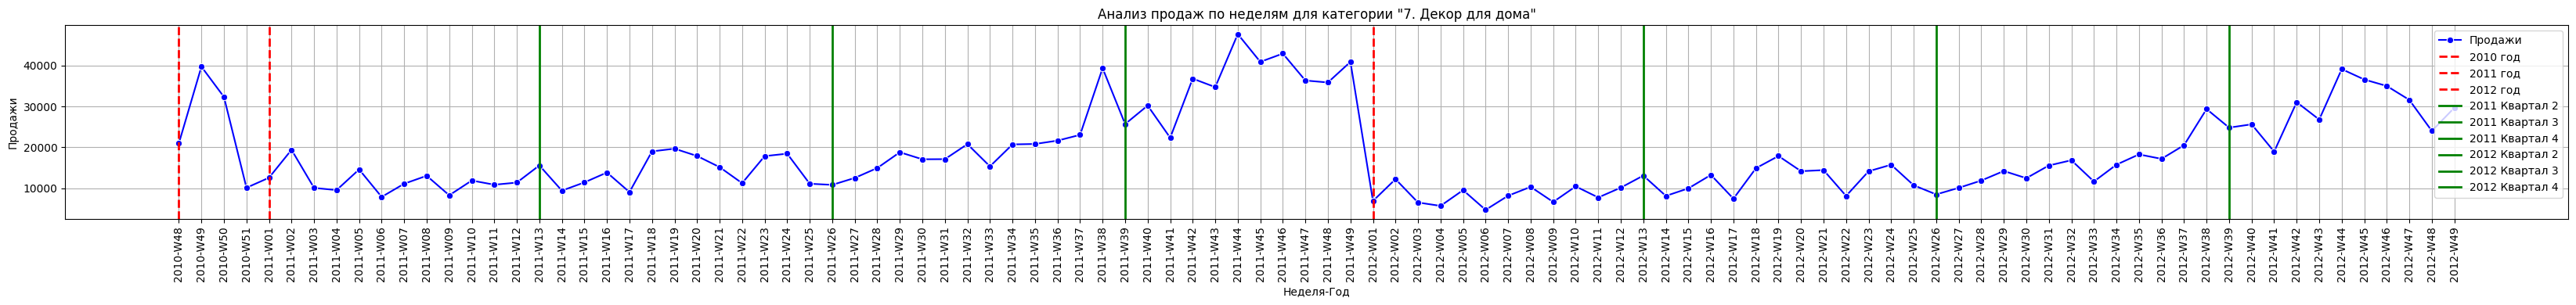

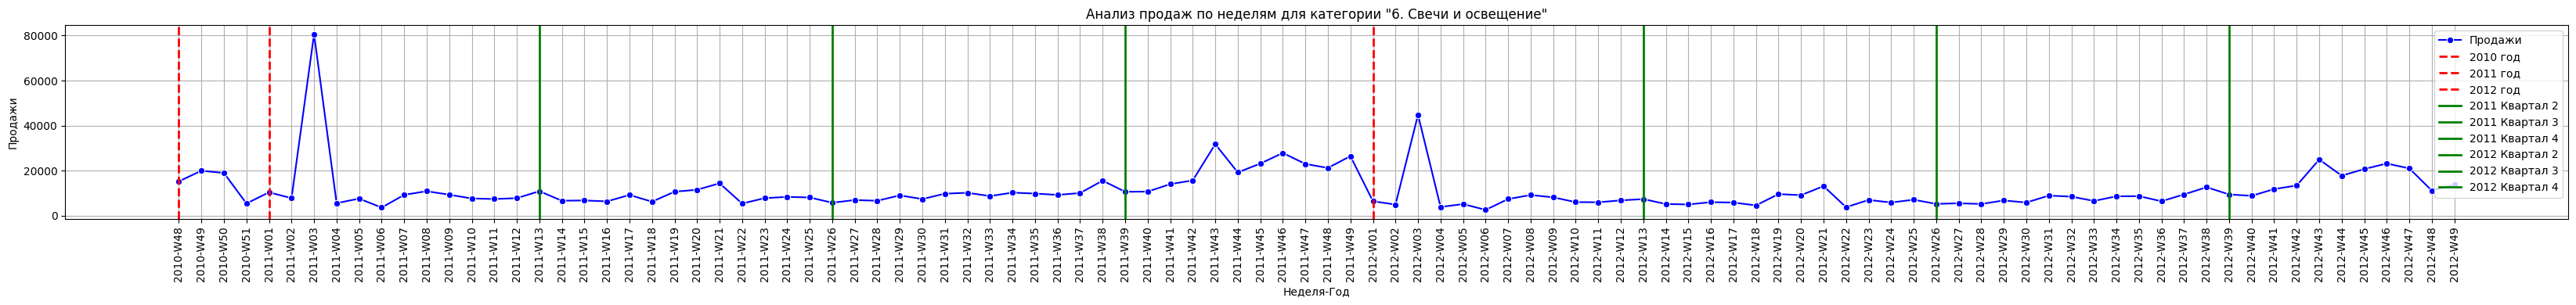

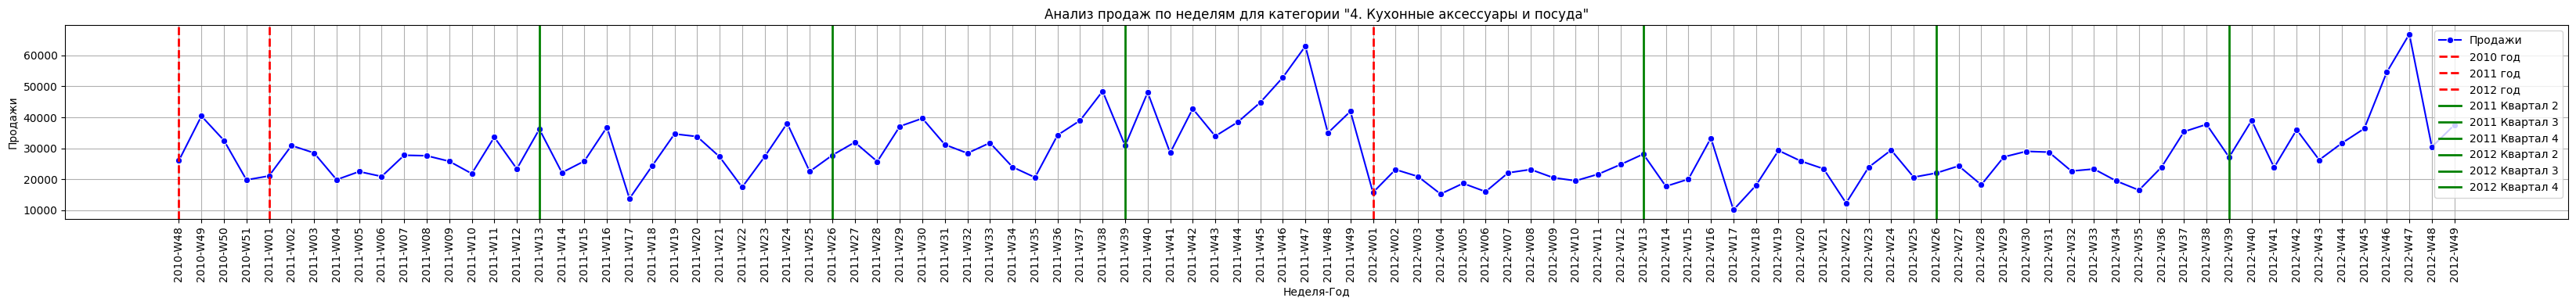

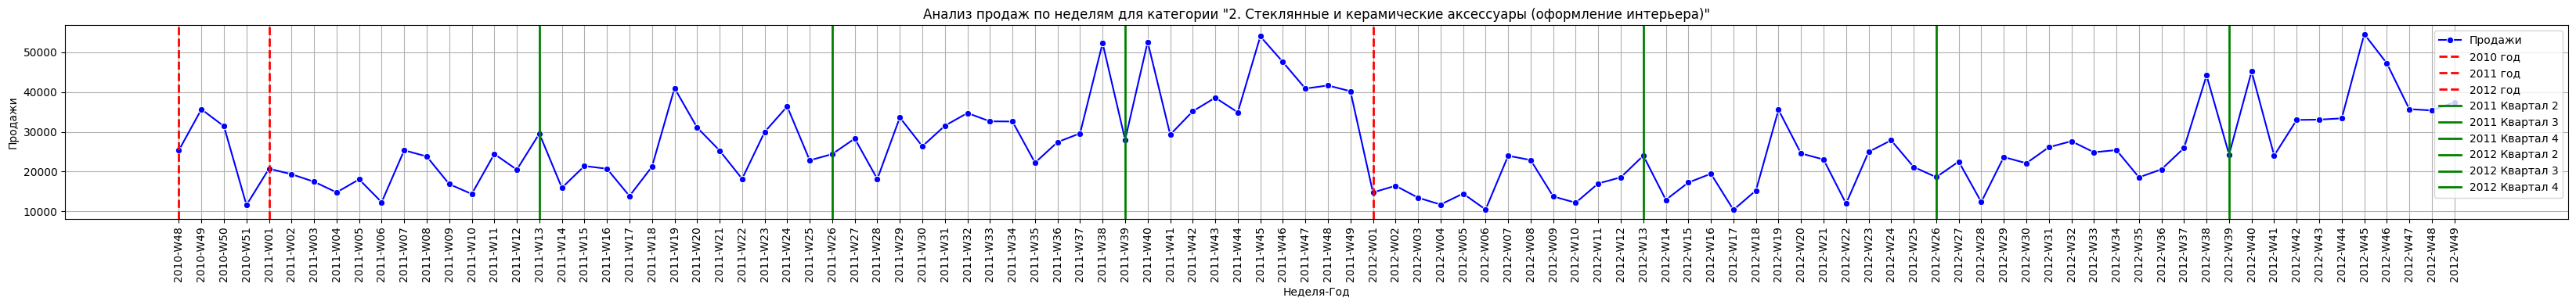

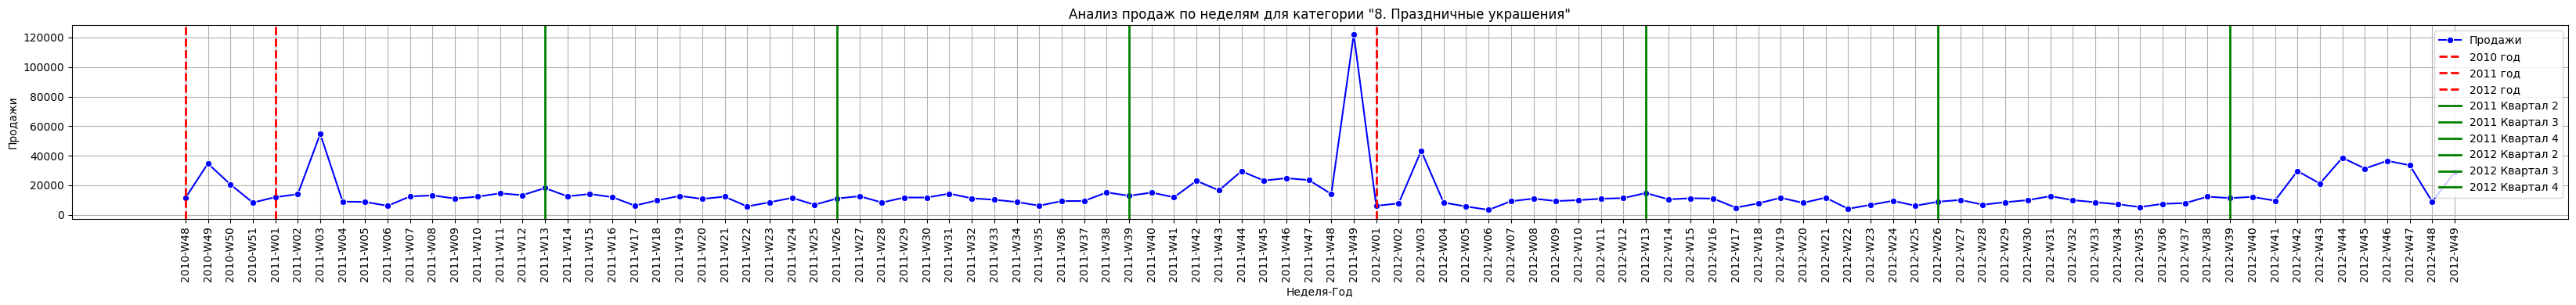

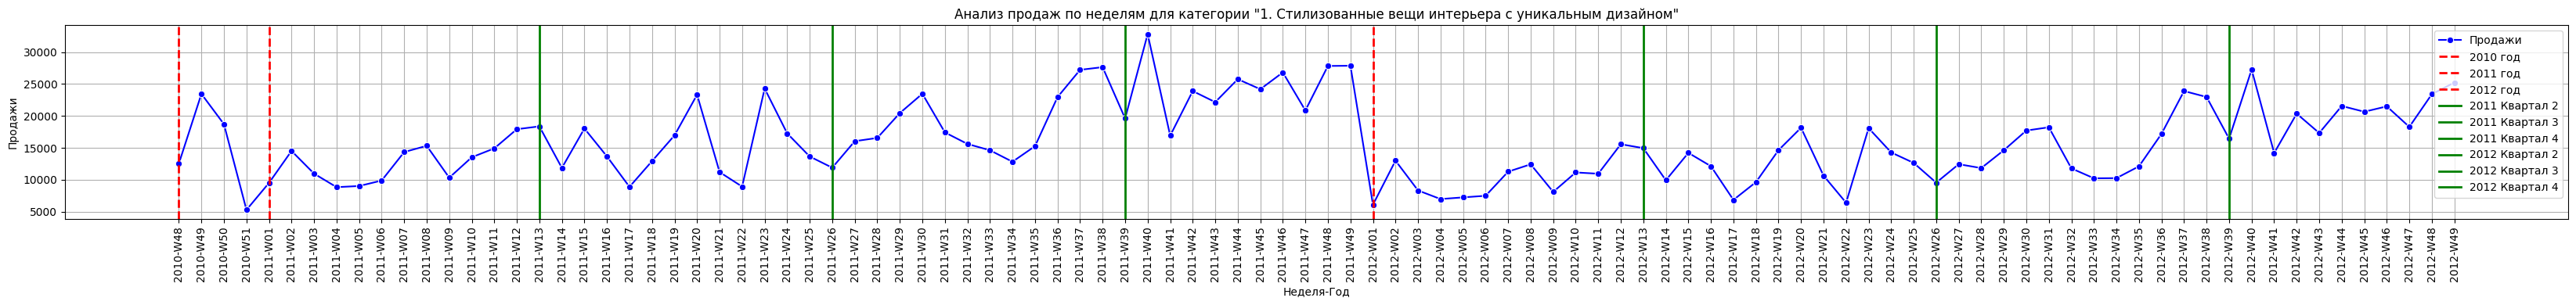

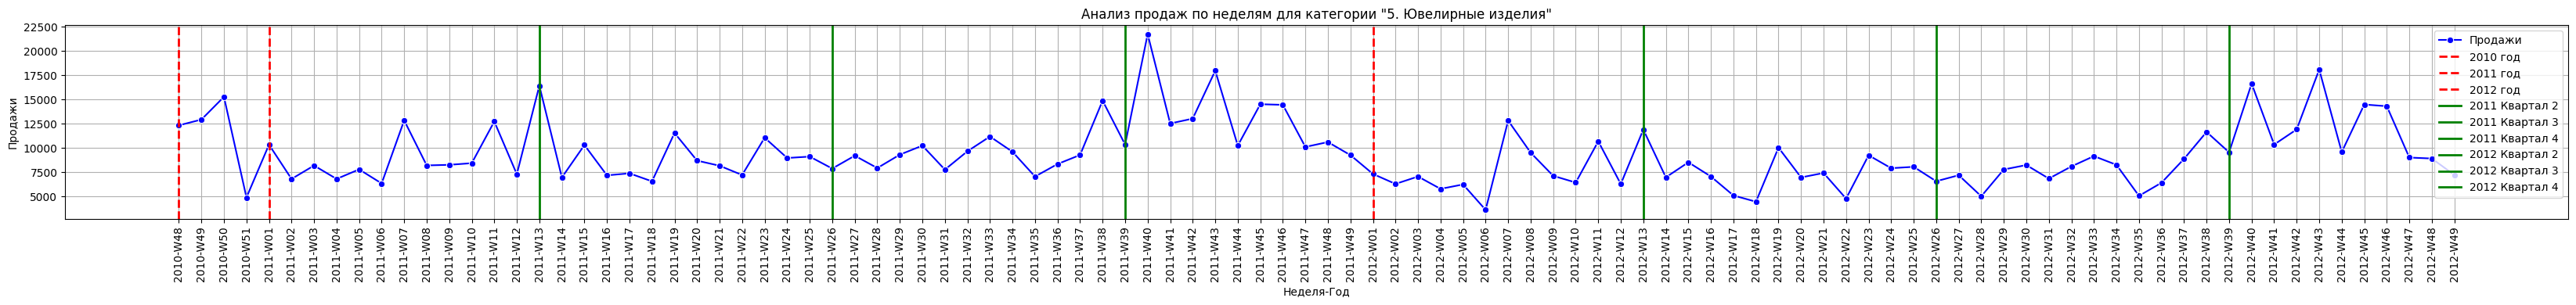

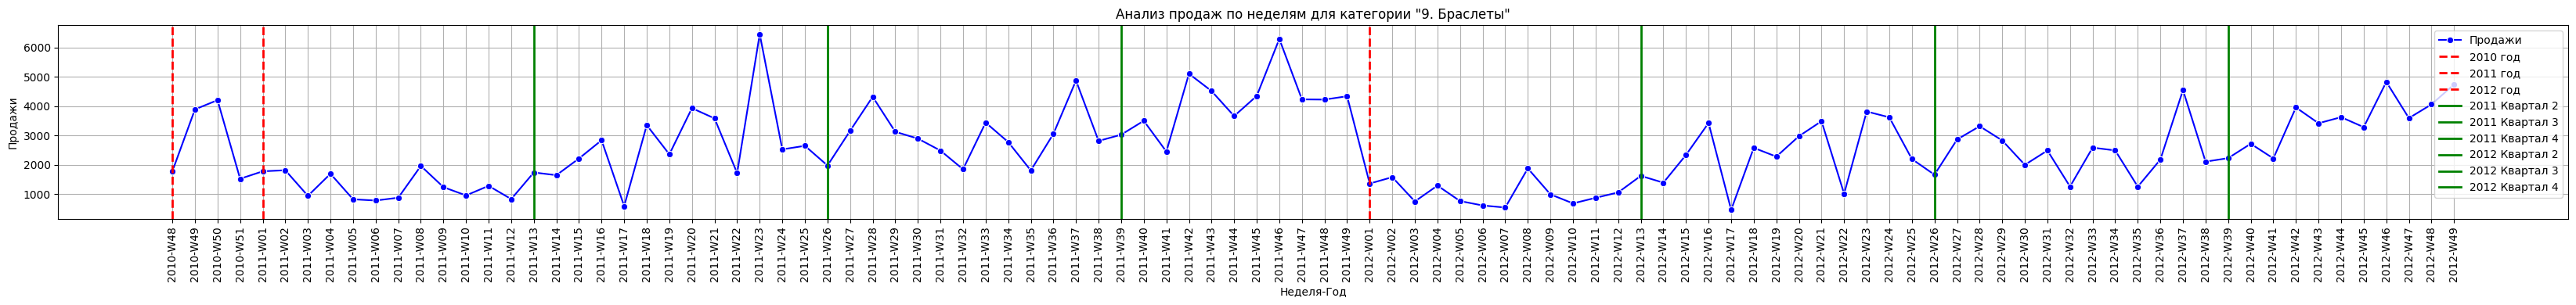

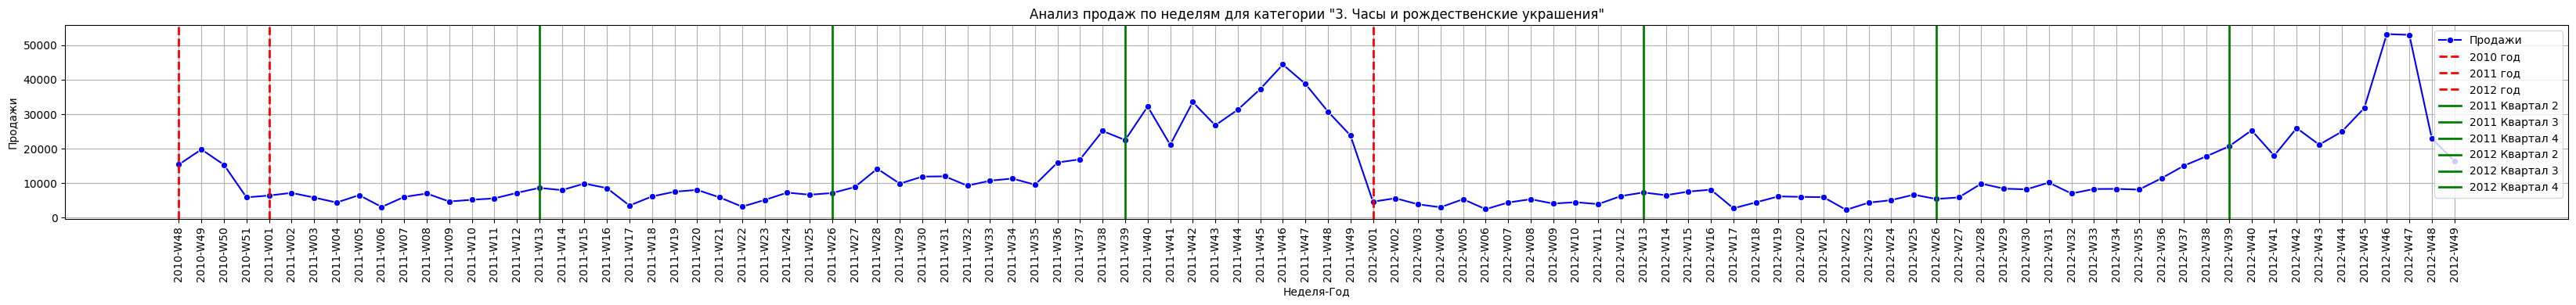

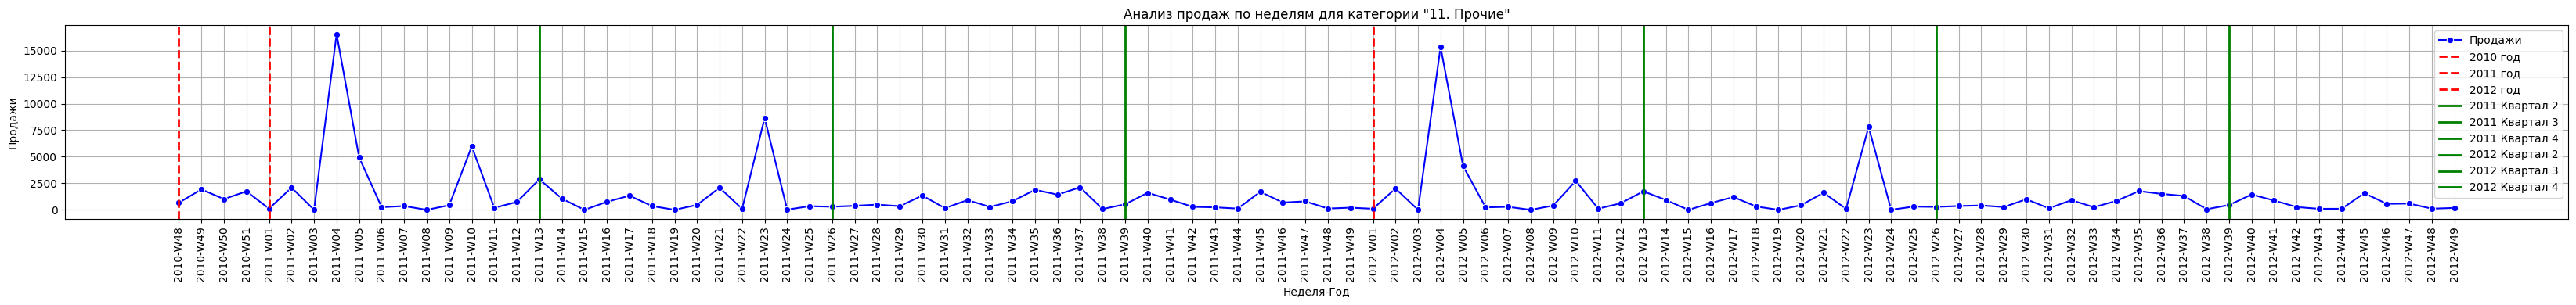

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_category_sales(df, category_name):
    # Фильтруем данные по выбранной категории
    data_category = df[df['category_name'] == category_name]
    
    # Группировка данных по неделям и годам
    sales_by_week_year = data_category.groupby(['Year', 'Week'])['Quantity'].sum().reset_index()
    
    # Создание новой колонки для отображения в формате 'Year-Week'
    sales_by_week_year['Year_Week'] = sales_by_week_year.apply(
        lambda row: f"{int(row['Year'])}-W{int(row['Week']):02d}", axis=1
    )
    
    # Создаем фигуру и оси
    fig, ax = plt.subplots(figsize=(33, 4))
    
    # Строим график сезонности продаж по неделям и годам
    sns.lineplot(x='Year_Week', y='Quantity', data=sales_by_week_year, marker='o', ax=ax, label='Продажи', color='blue')
    
    # Настройка формата оси X
    ax.set_title(f'Анализ продаж по неделям для категории "{category_name}"')
    ax.set_xlabel('Неделя-Год')
    ax.set_ylabel('Продажи')
    
    # Настройка формата оси X для отображения всех недель
    ax.set_xticks(sales_by_week_year['Year_Week'])  # Устанавливаем все недели как метки
    ax.set_xticklabels(sales_by_week_year['Year_Week'], rotation=90)  # Поворачиваем метки для удобства чтения

    # Добавляем линии для разделения годов
    years = sales_by_week_year['Year'].unique()
    for year in years:
        year_label = f"{int(year)}"
        year_weeks = sales_by_week_year[sales_by_week_year['Year'] == year]['Year_Week']
        # Отмечаем начало каждого года вертикальной линией
        ax.axvline(x=year_weeks.iloc[0], color='red', linestyle='--', linewidth=2, label=f'{year} год')

    # Добавляем линии для разделения кварталов
    for year in years:
        quarters = [13, 26, 39, 52]  # Начало каждого квартала
        for week in quarters:
            week_label = f"{int(year)}-W{week:02d}"
            if week_label in sales_by_week_year['Year_Week'].values:
                ax.axvline(x=week_label, color='green', linestyle='-', linewidth=2, label=f'{year} Квартал {week//13 + 1}')
    
    # Удаляем дублирующиеся записи в легенде
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    # Включение сетки
    ax.grid(True)
    
    # Показываем график
    plt.tight_layout()
    plt.show()

# Вызов функции для каждой категории
categories = df_with_category['category_name'].unique()
for category in categories:
    plot_category_sales(df_with_category, category)


In [197]:
df_with_category

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         9   
1         536365     71053                  WHITE METAL LANTERN        10   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         9   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         7   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         9   
...          ...       ...                                  ...       ...   
966418    581019    84251G     GREETING CARD, OVERCROWDED POOL.         6   
966419    581439    17084P                DRAGONS BLOOD INCENSE         9   
966420    580744     22899          CHILDREN'S APRON DOLLY GIRL        23   
966421    580730     21288      STRIPEY CHOCOLATE NESTING BOXES         6   
966422    580730     21137             BLACK RECORD COVER FRAME         8   

               InvoiceDate  UnitPrice  CustomerID         Country  Return  \
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       0   
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       0   
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
...                    ...        ...         ...             ...     ...   
966418 2012-12-07 10:11:00       0.19       14794  United Kingdom       0   
966419 2012-12-08 16:30:00       0.42     -999999  United Kingdom       0   
966420 2012-12-06 09:31:00       1.85       13694  United Kingdom       0   
966421 2012-12-05 17:28:00       3.29     -999999  United Kingdom       0   
966422 2012-12-05 17:28:00       4.13     -999999  United Kingdom       0   

       clusters_4                       category_name  Week  Month  Year  \
0             6.0                   7. Декор для дома    48     12  2010   
1             5.0                6. Свечи и освещение    48     12  2010   
2             6.0                   7. Декор для дома    48     12  2010   
3             6.0                   7. Декор для дома    48     12  2010   
4             6.0                   7. Декор для дома    48     12  2010   
...           ...                                 ...   ...    ...   ...   
966418        2.0  3. Часы и рождественские украшения    49     12  2012   
966419        5.0                6. Свечи и освещение    49     12  2012   
966420        7.0            8. Праздничные украшения    49     12  2012   
966421        7.0            8. Праздничные украшения    49     12  2012   
966422        6.0                   7. Декор для дома    49     12  2012   

                      Дата  
0      2010-12-01 08:26:00  
1      2010-12-01 08:26:00  
2      2010-12-01 08:26:00  
3      2010-12-01 08:26:00  
4      2010-12-01 08:26:00  
...                    ...  
966418 2012-12-07 10:11:00  
966419 2012-12-08 16:30:00  
966420 2012-12-06 09:31:00  
966421 2012-12-05 17:28:00  
966422 2012-12-05 17:28:00  

[966423 rows x 15 columns]



Категория: 7. Декор для дома


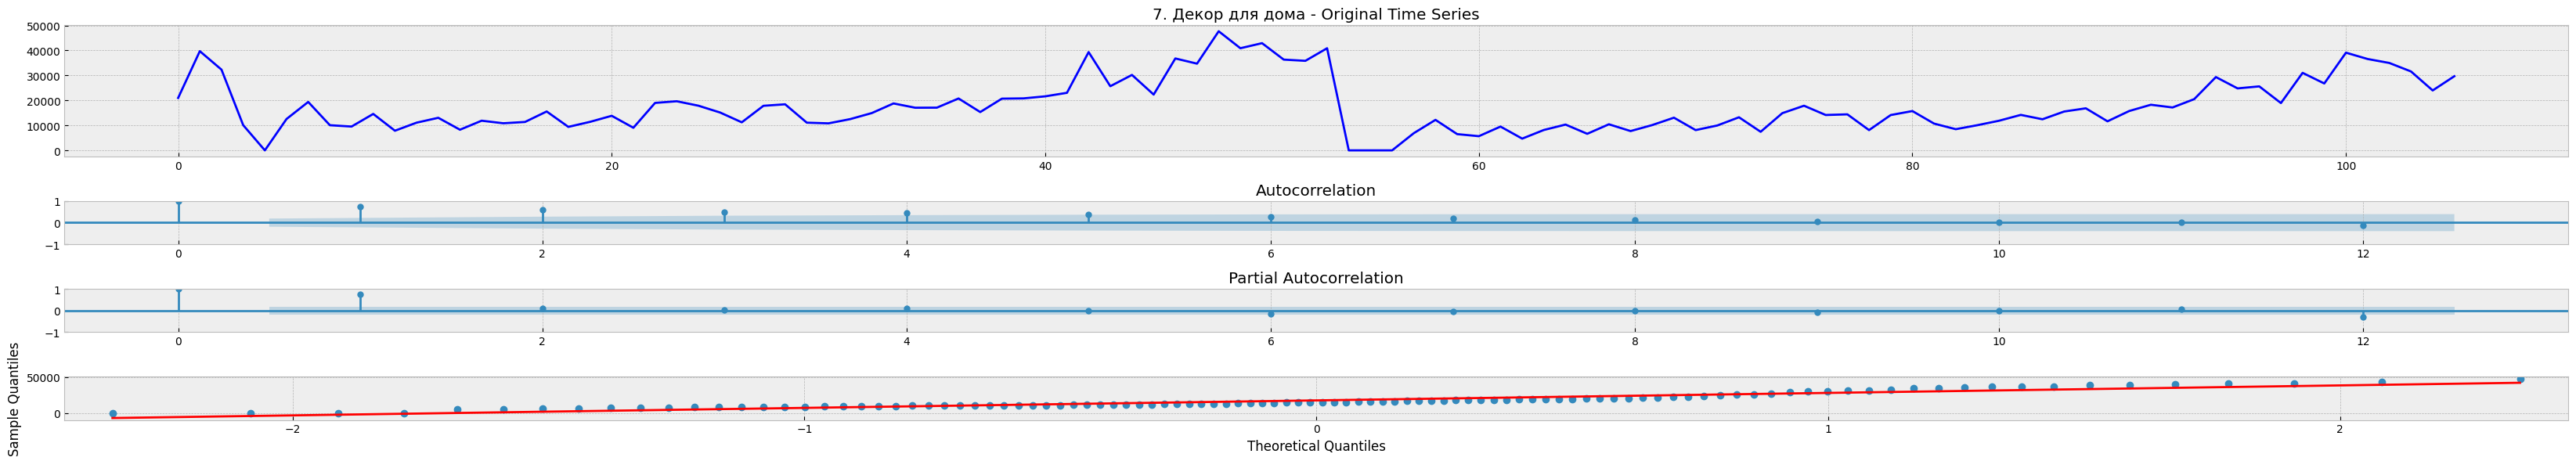

01:37:53 - cmdstanpy - INFO - Chain [1] start processing
01:37:53 - cmdstanpy - INFO - Chain [1] done processing


Категория - 7. Декор для дома
Лучший MSE: 11350537.71080, MAE: 2676.23406, R²: 0.83396, MAPE: 12.22%


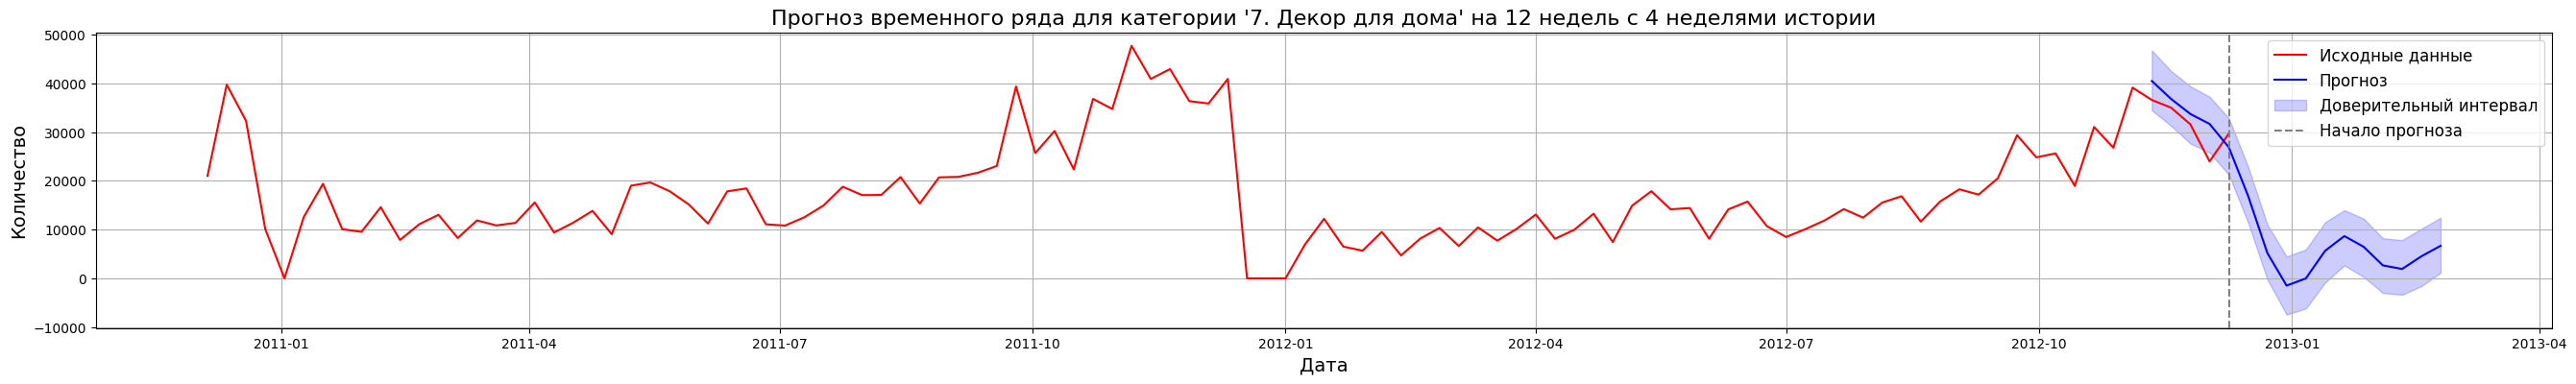



Категория: 6. Свечи и освещение


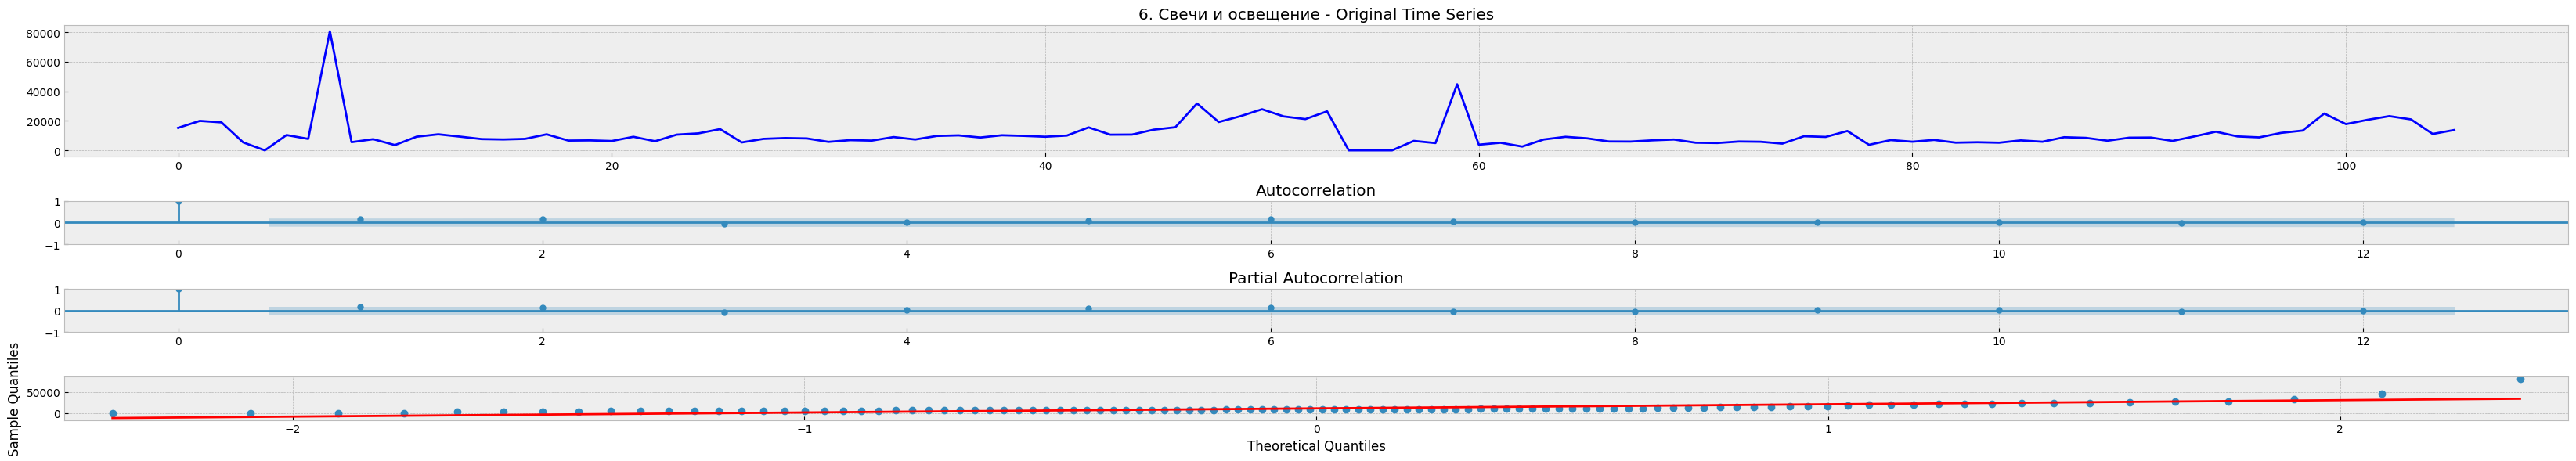

01:37:54 - cmdstanpy - INFO - Chain [1] start processing
01:37:54 - cmdstanpy - INFO - Chain [1] done processing


Категория - 6. Свечи и освещение
Лучший MSE: 10424863.82904, MAE: 2461.91623, R²: 0.68574, MAPE: 19.53%


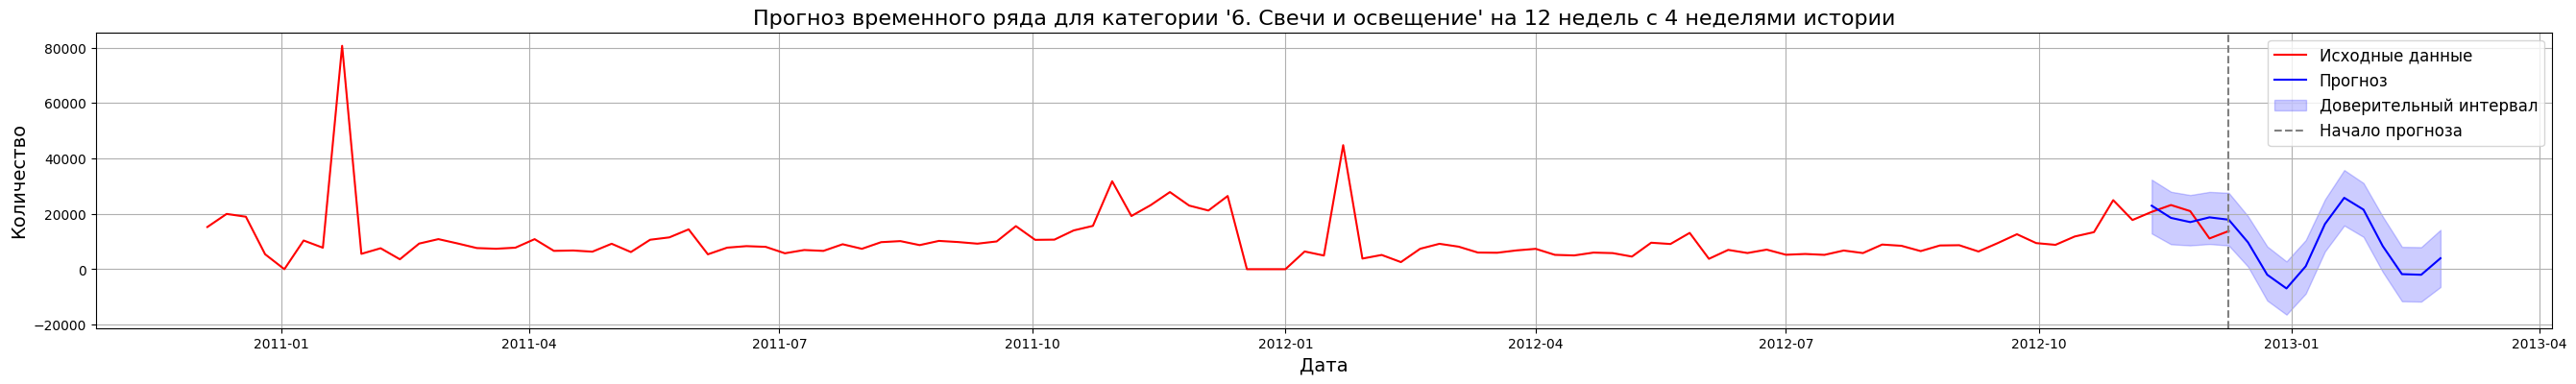



Категория: 4. Кухонные аксессуары и посуда


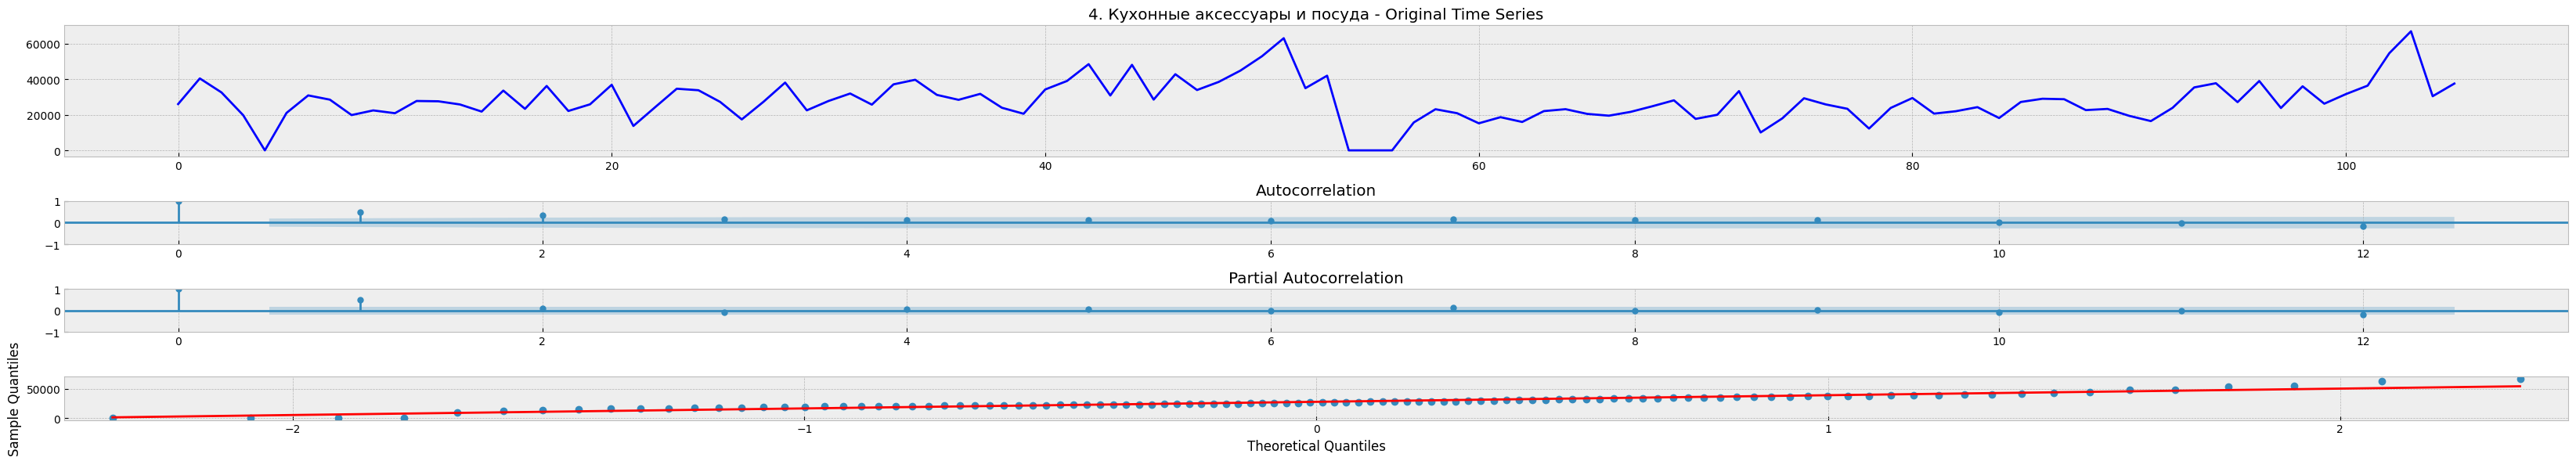

01:37:55 - cmdstanpy - INFO - Chain [1] start processing
01:37:55 - cmdstanpy - INFO - Chain [1] done processing


Категория - 4. Кухонные аксессуары и посуда
Лучший MSE: 50428579.16701, MAE: 5424.22195, R²: 0.61381, MAPE: 16.78%


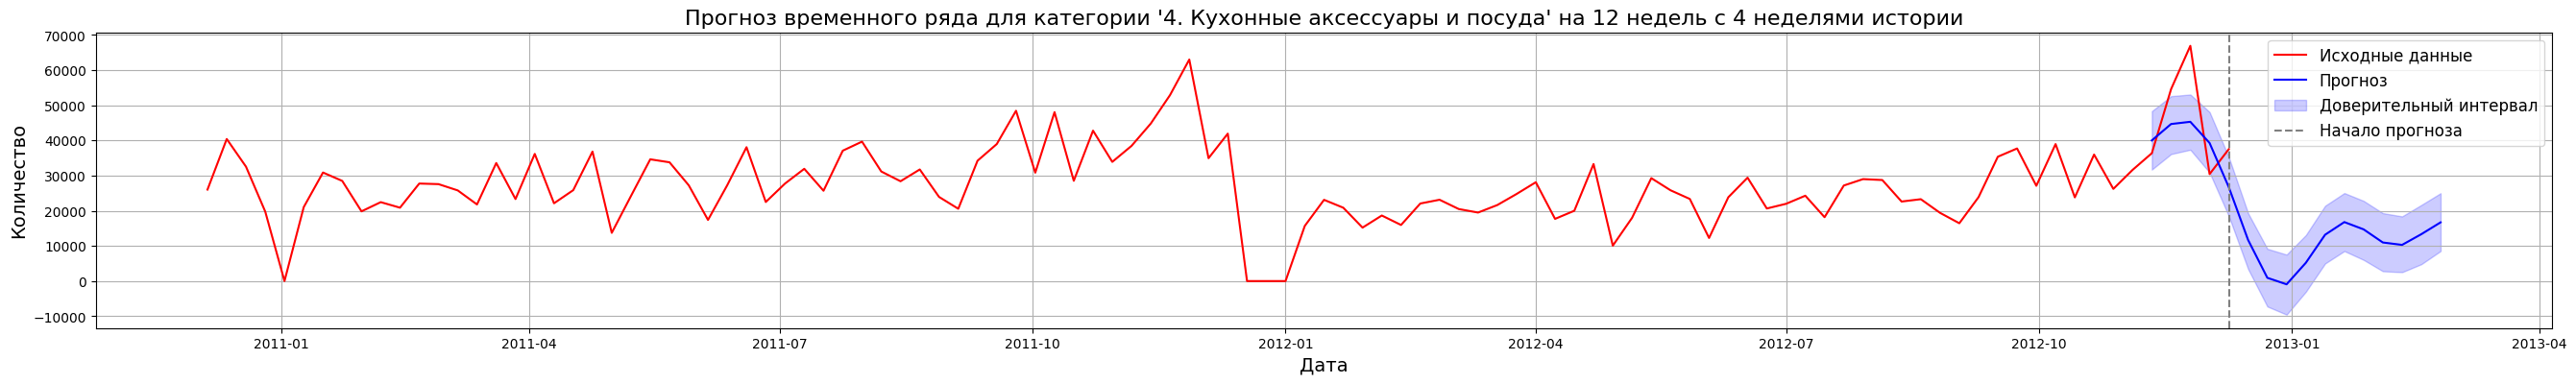



Категория: 2. Стеклянные и керамические аксессуары (оформление интерьера)


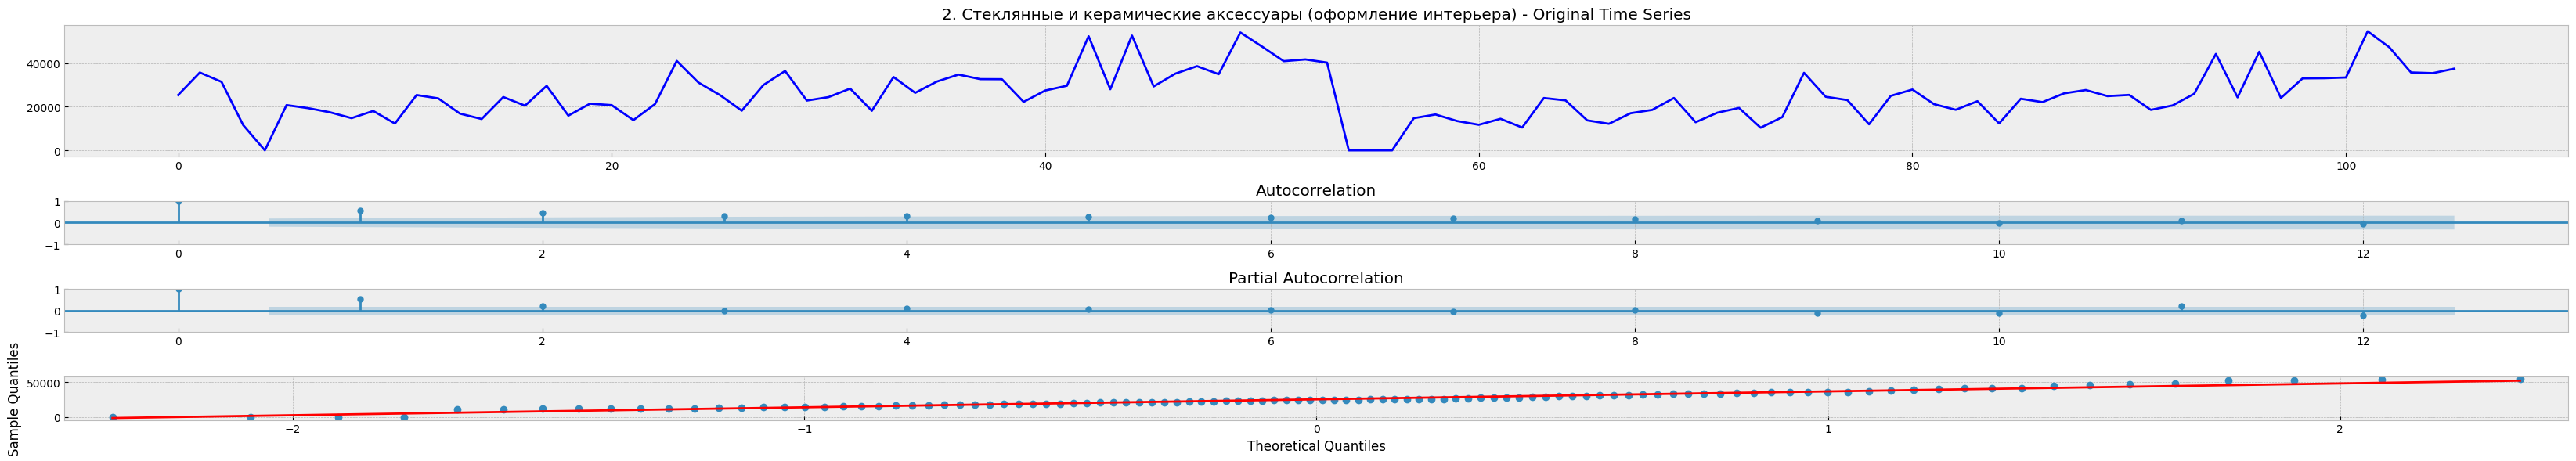

01:37:56 - cmdstanpy - INFO - Chain [1] start processing
01:37:56 - cmdstanpy - INFO - Chain [1] done processing


Категория - 2. Стеклянные и керамические аксессуары (оформление интерьера)
Лучший MSE: 41708817.13495, MAE: 5011.73094, R²: 0.59337, MAPE: 17.61%


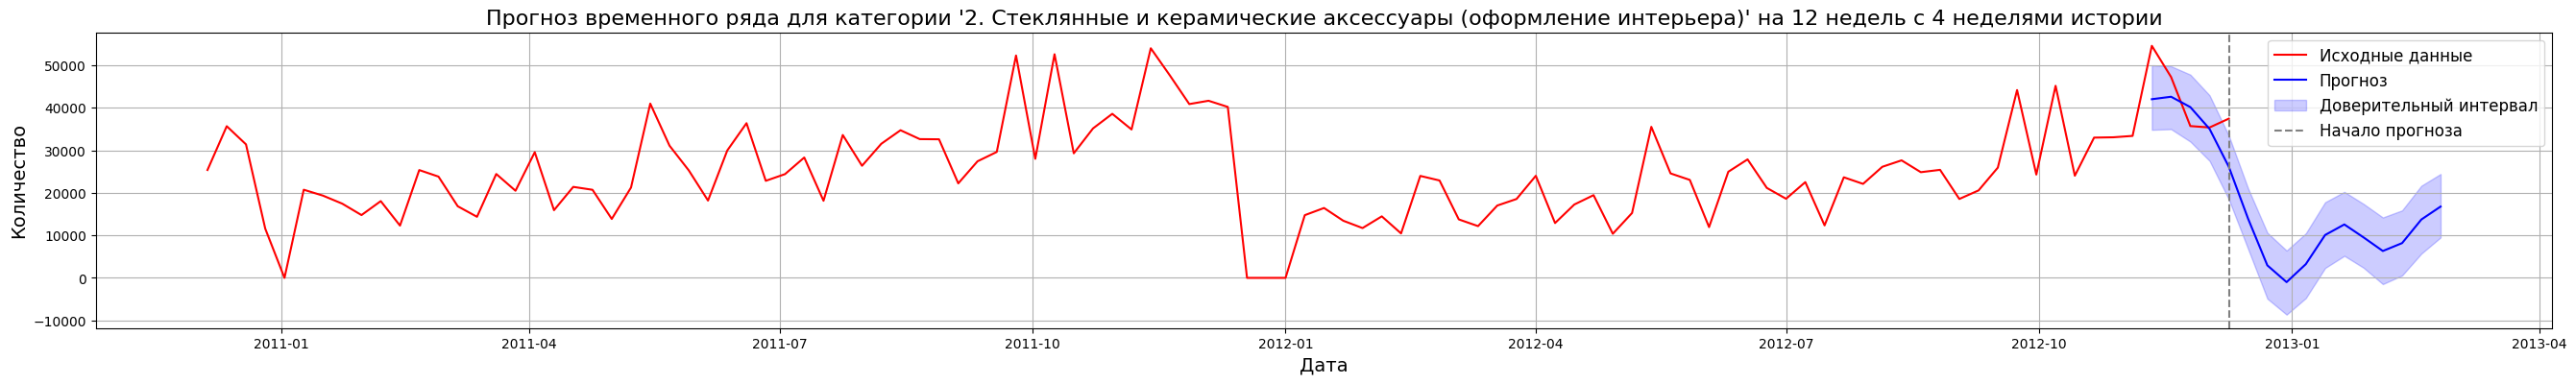



Категория: 8. Праздничные украшения


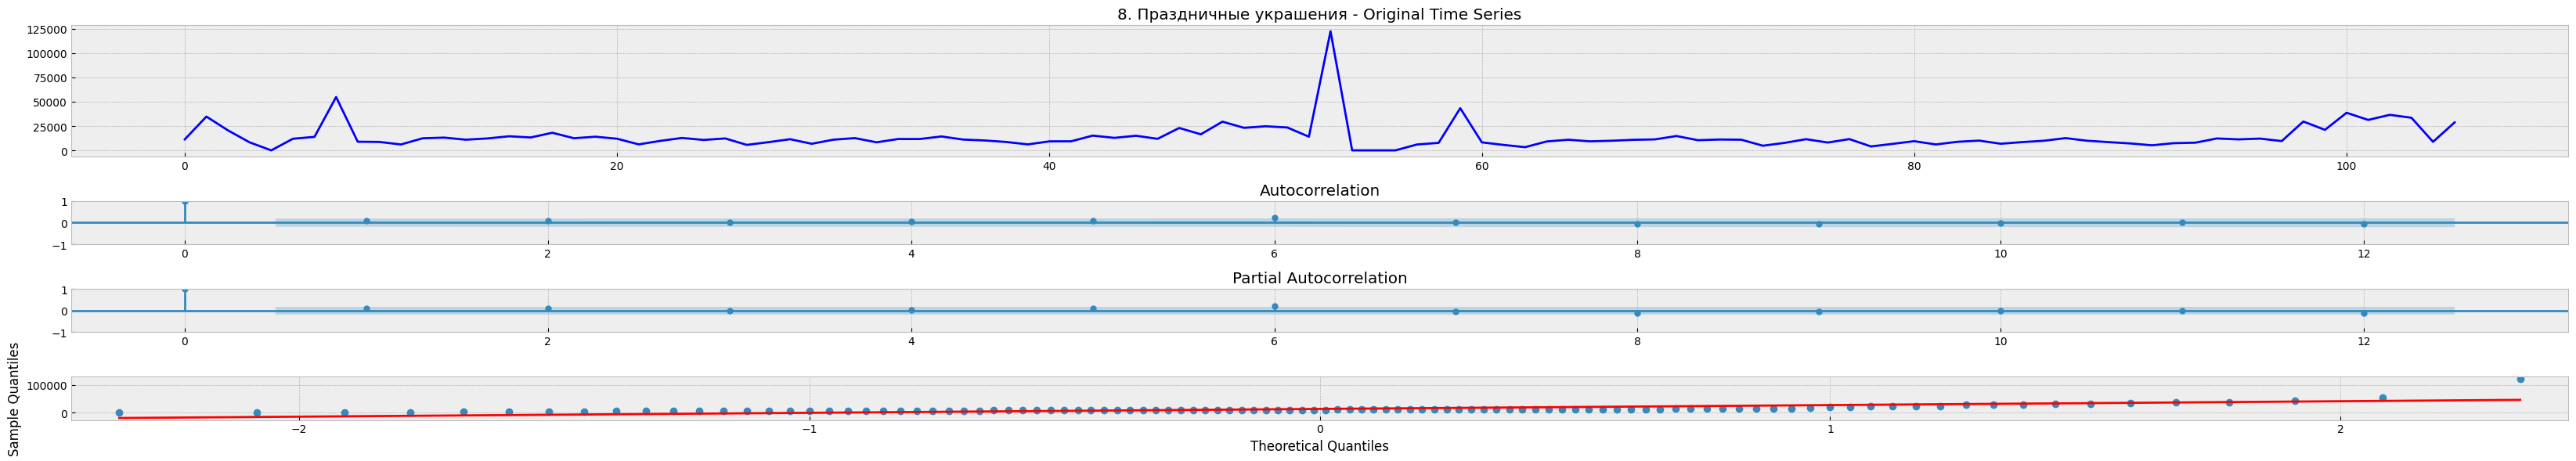

01:37:57 - cmdstanpy - INFO - Chain [1] start processing
01:37:57 - cmdstanpy - INFO - Chain [1] done processing


Категория - 8. Праздничные украшения
Лучший MSE: 90209176.81129, MAE: 6682.85067, R²: 0.23991, MAPE: 44.25%


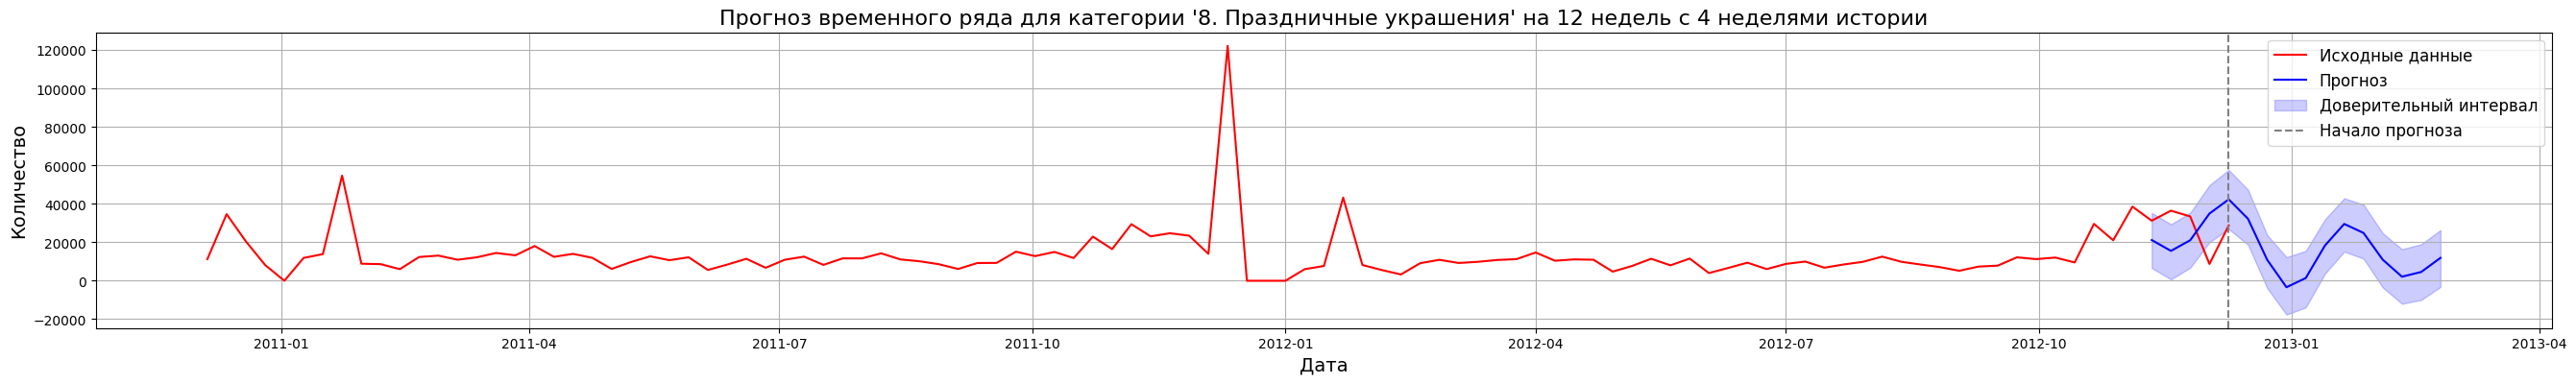



Категория: 1. Стилизованные вещи интерьера с уникальным дизайном


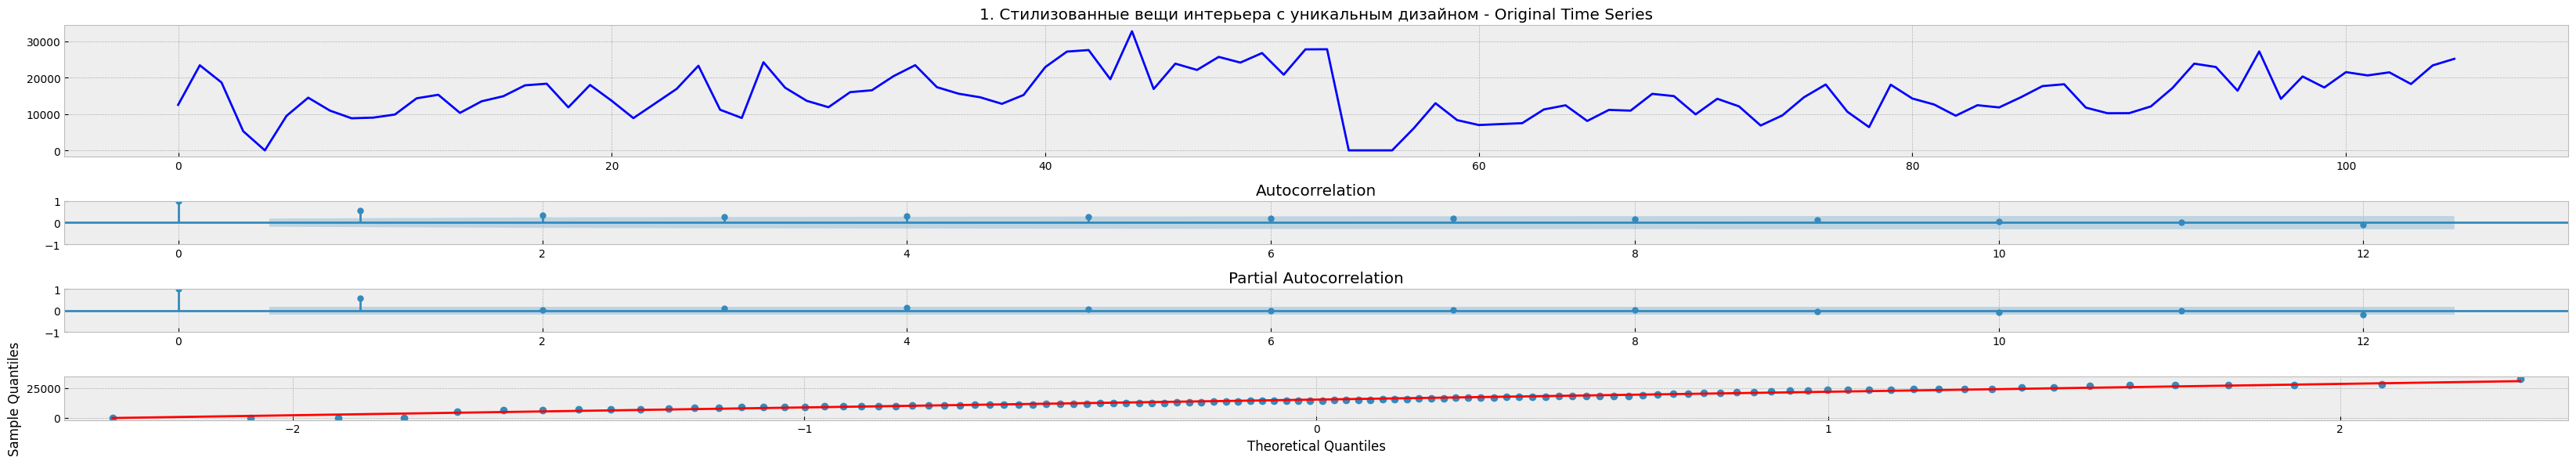

01:37:58 - cmdstanpy - INFO - Chain [1] start processing
01:37:58 - cmdstanpy - INFO - Chain [1] done processing


Категория - 1. Стилизованные вещи интерьера с уникальным дизайном
Лучший MSE: 11633662.61878, MAE: 2532.39643, R²: 0.51289, MAPE: 14.29%


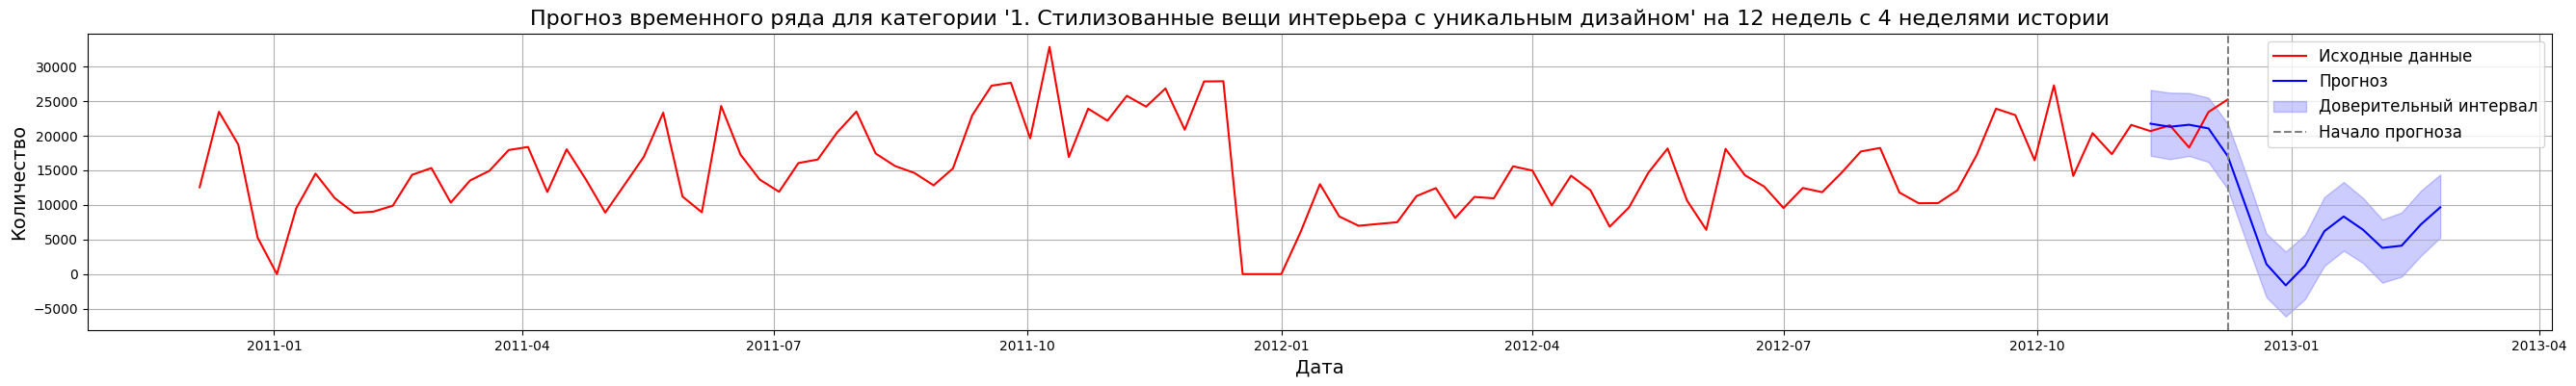



Категория: 5. Ювелирные изделия


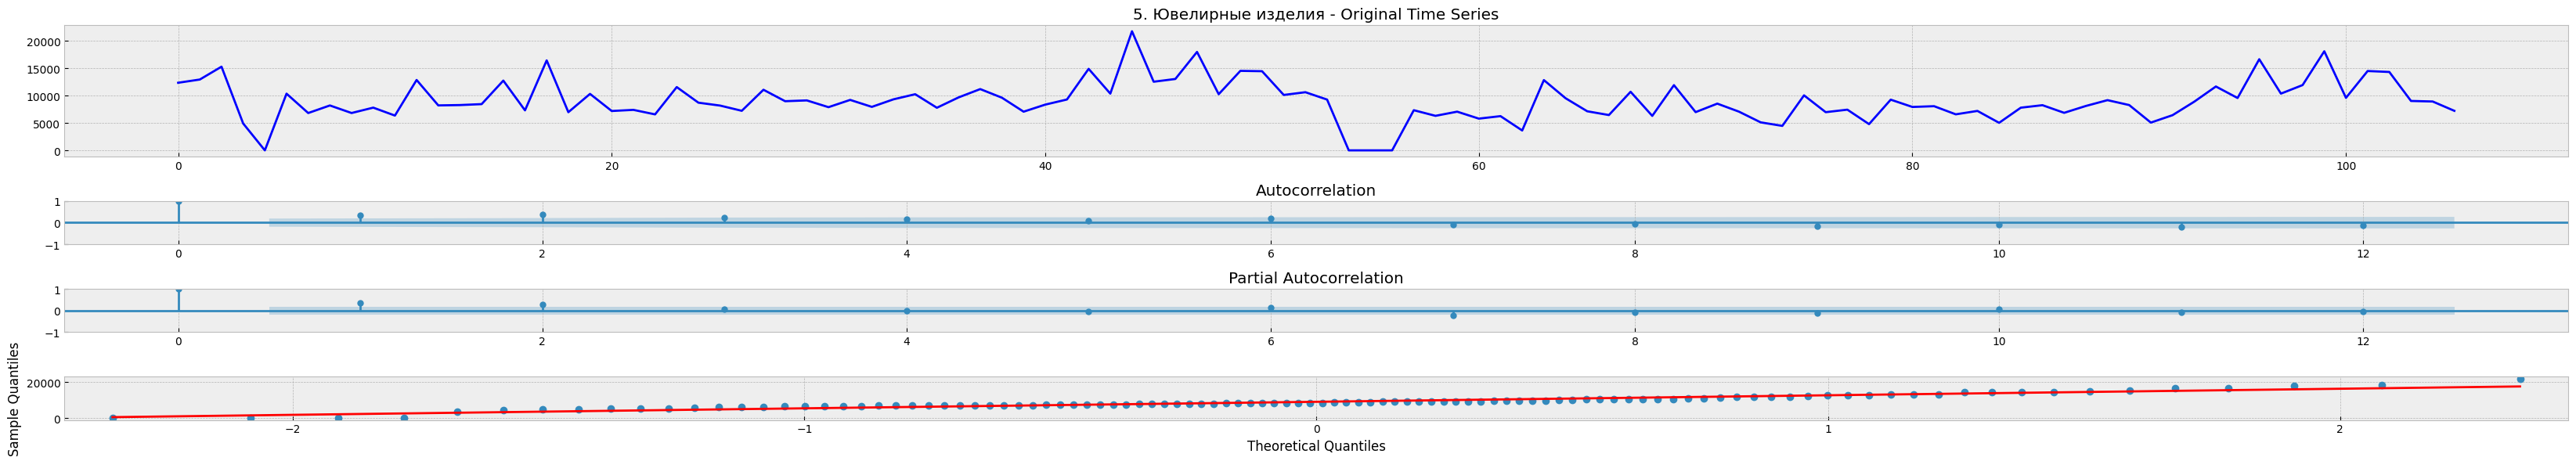

01:37:59 - cmdstanpy - INFO - Chain [1] start processing
01:38:00 - cmdstanpy - INFO - Chain [1] done processing


Категория - 5. Ювелирные изделия
Лучший MSE: 4998497.96486, MAE: 1749.36612, R²: 0.56511, MAPE: 16.97%


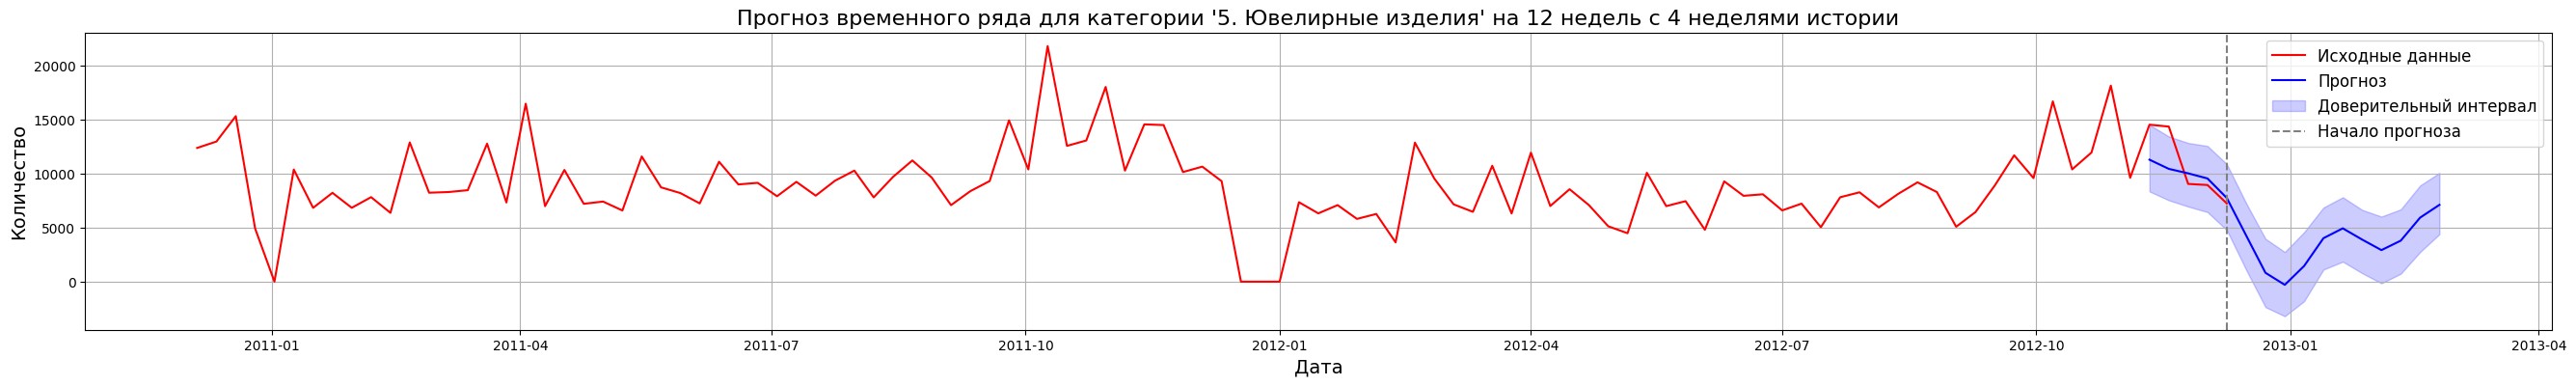



Категория: 9. Браслеты


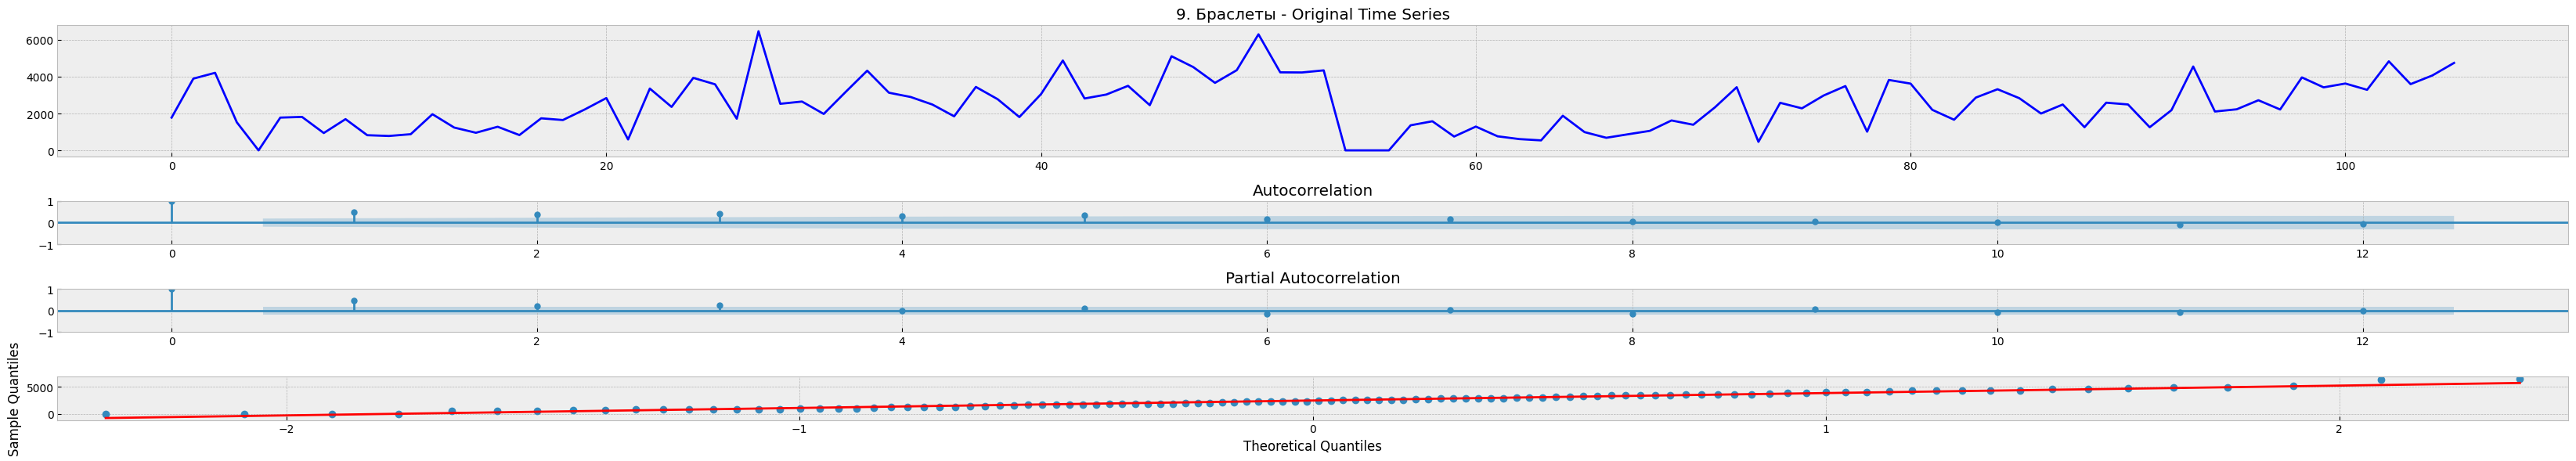

01:38:00 - cmdstanpy - INFO - Chain [1] start processing
01:38:01 - cmdstanpy - INFO - Chain [1] done processing


Категория - 9. Браслеты
Лучший MSE: 709302.45996, MAE: 724.80956, R²: 0.30688, MAPE: 28.45%


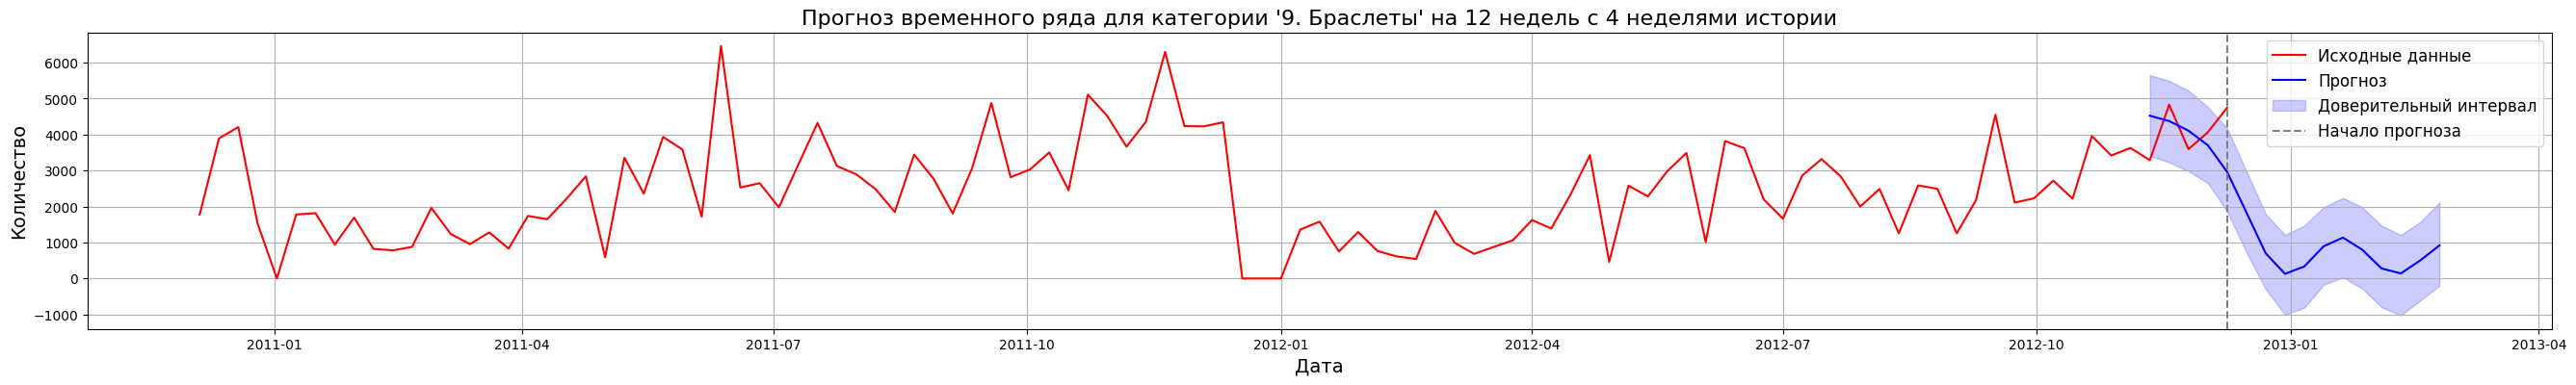



Категория: 3. Часы и рождественские украшения


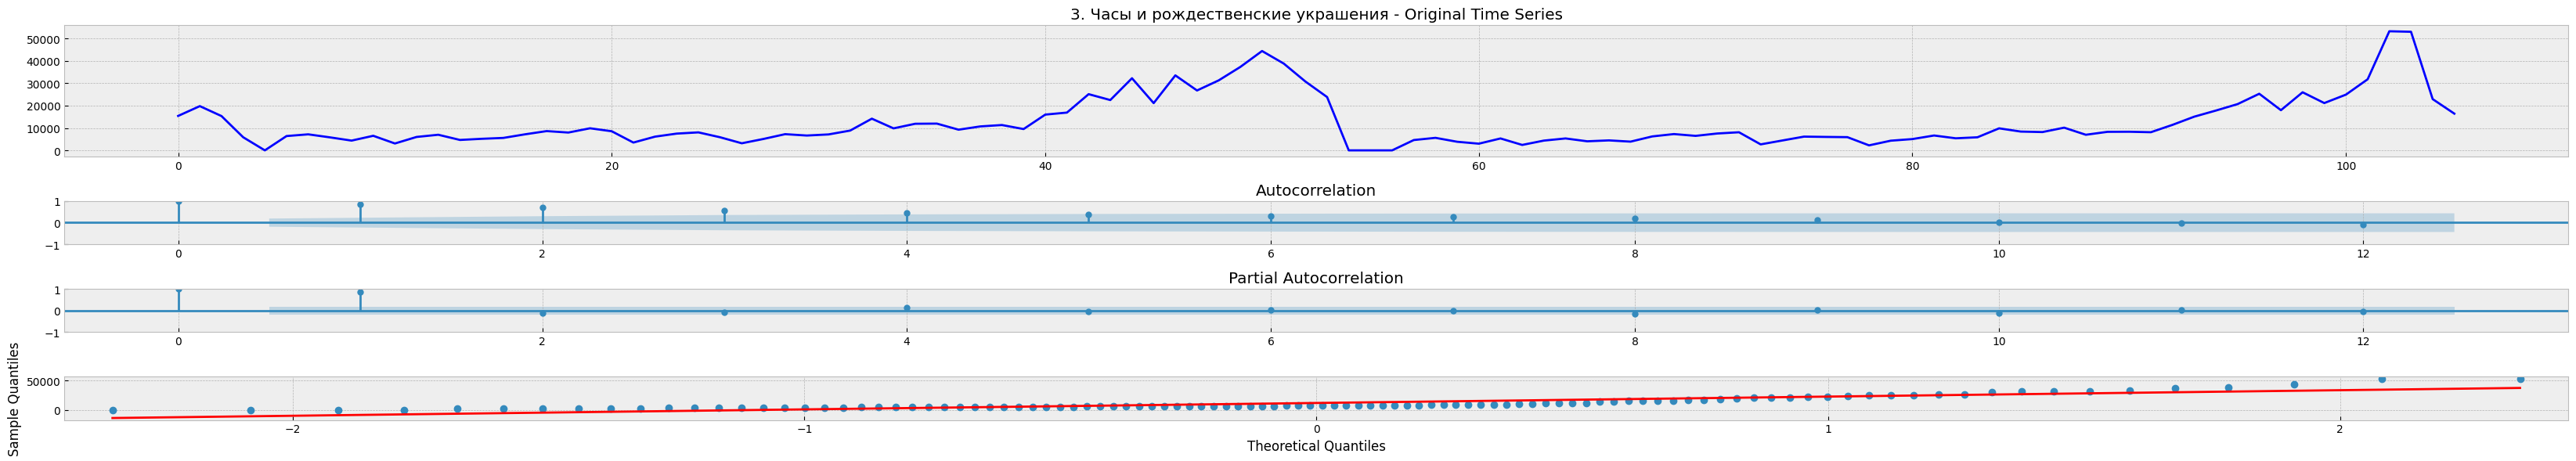

01:38:01 - cmdstanpy - INFO - Chain [1] start processing
01:38:02 - cmdstanpy - INFO - Chain [1] done processing


Категория - 3. Часы и рождественские украшения
Лучший MSE: 31085967.95249, MAE: 3750.65587, R²: 0.81026, MAPE: 17.87%


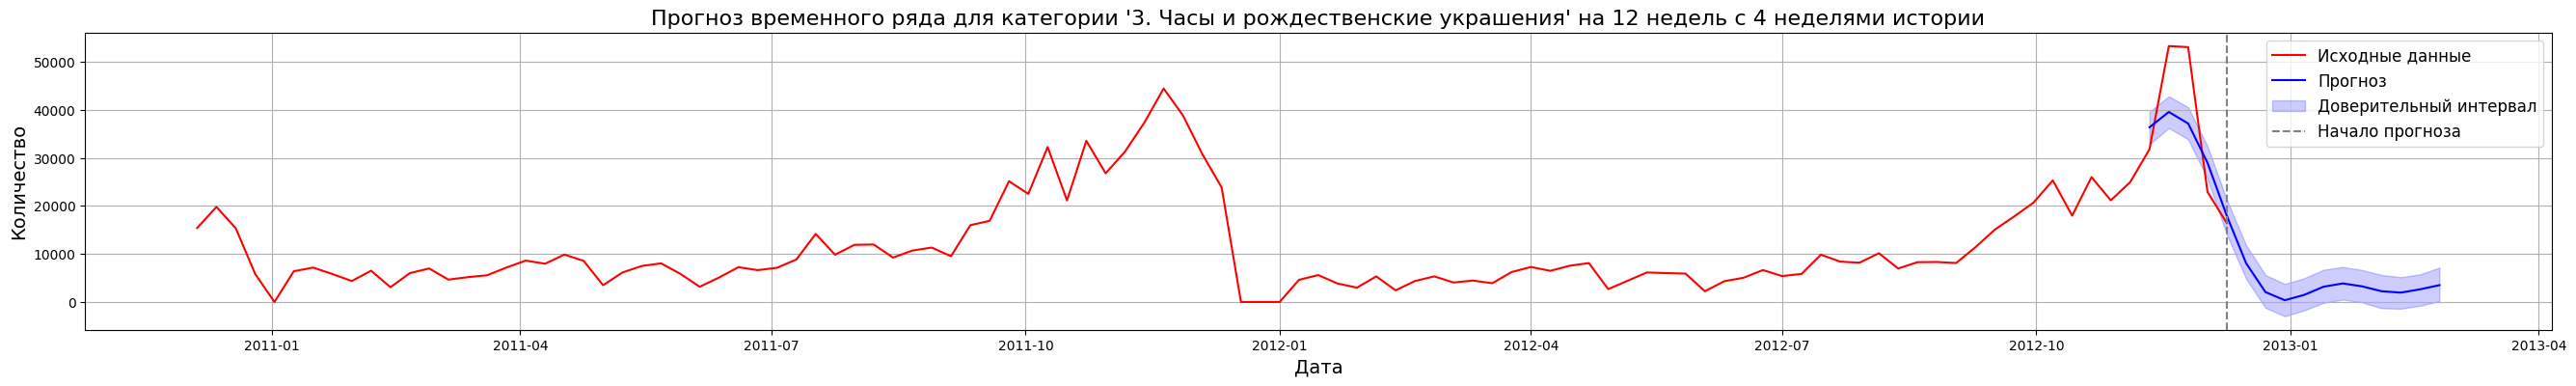



Категория: 11. Прочие


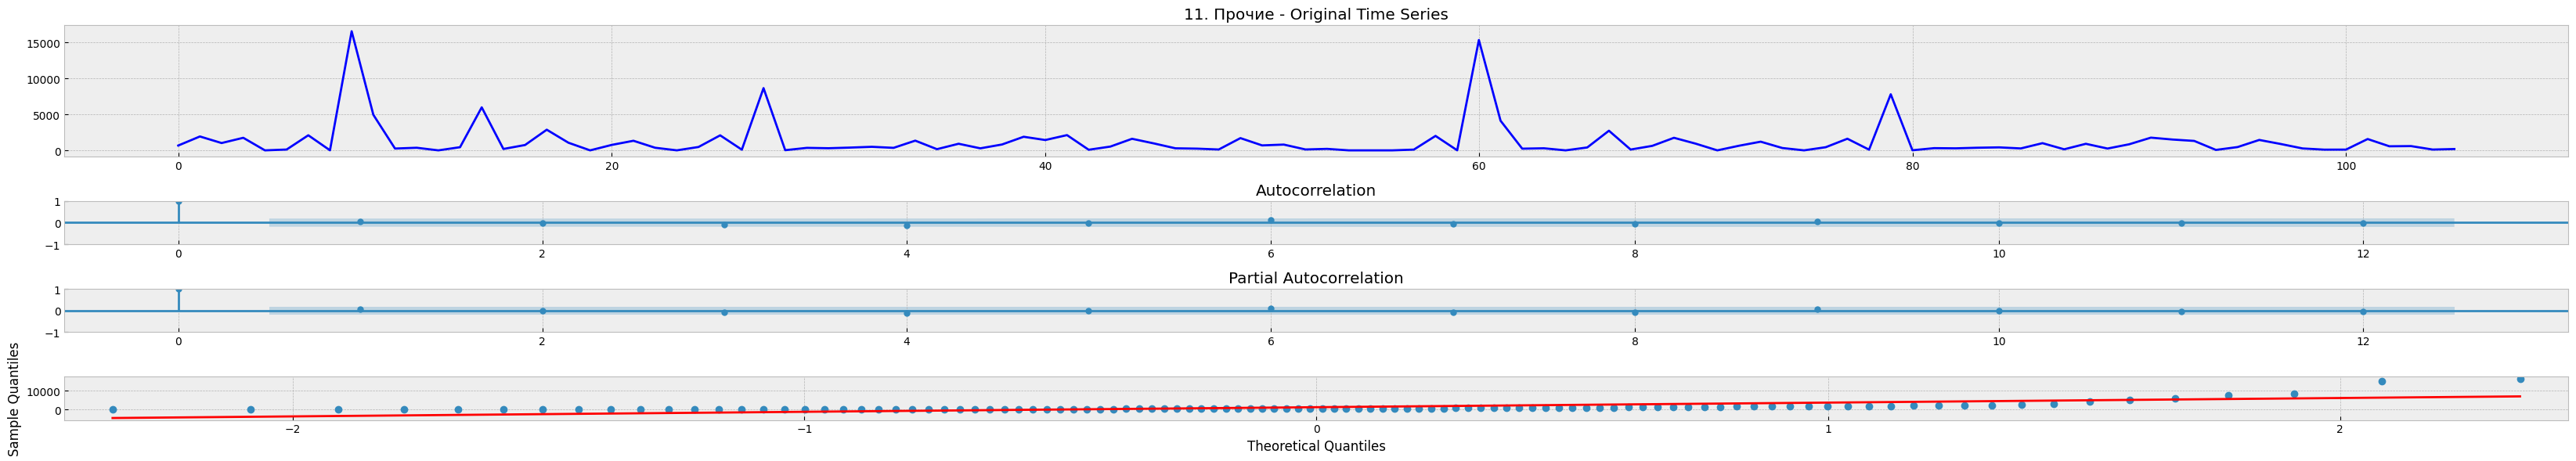

01:38:02 - cmdstanpy - INFO - Chain [1] start processing
01:38:02 - cmdstanpy - INFO - Chain [1] done processing


Категория - 11. Прочие
Лучший MSE: 296873.21333, MAE: 404.48178, R²: -0.01473, MAPE: 132.91%


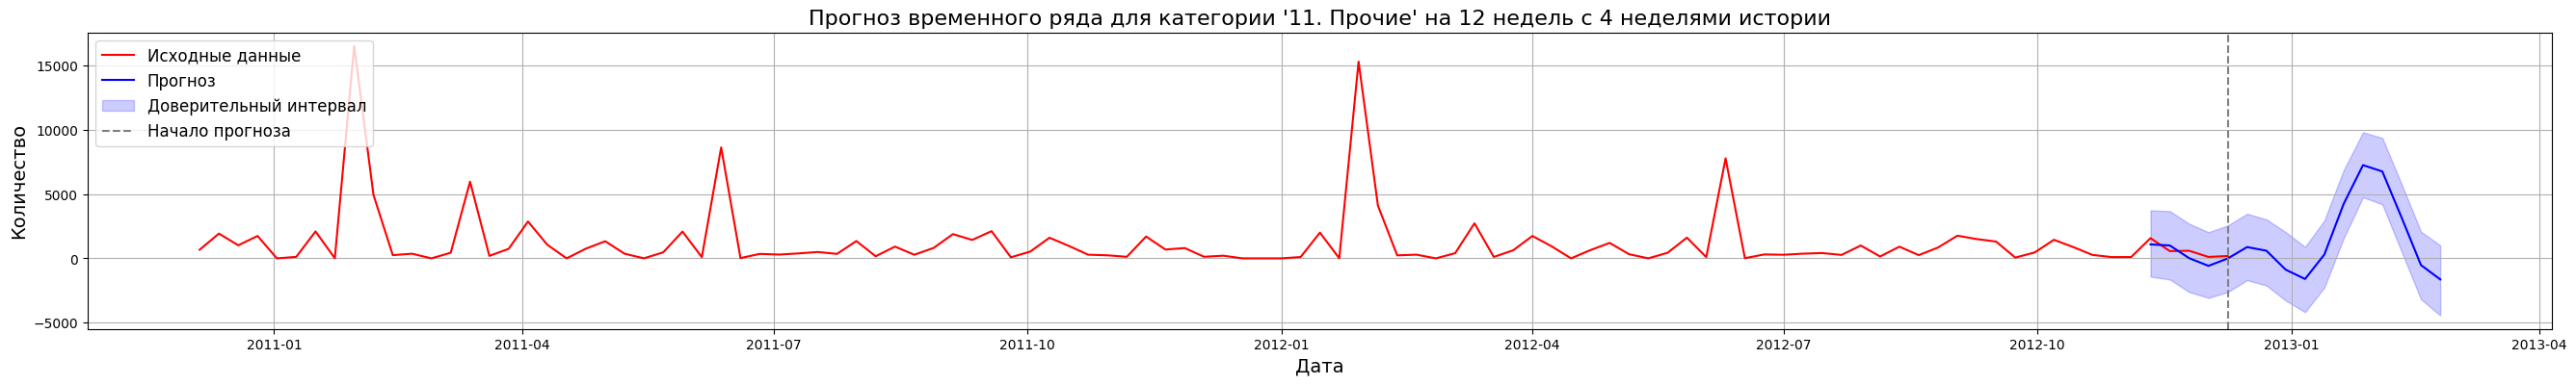

In [198]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

# Преобразование даты и извлечение уникальных категорий
df_with_category['Дата'] = pd.to_datetime(df_with_category['InvoiceDate'])
categories = df_with_category['category_name'].unique()

def tsplot(name, y, lags=None, figsize=(33, 6), style='bmh'):
    """ Функция для построения временного ряда и графиков автокорреляции. """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Original')
        ts_ax.set_title(name)

        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
        plt.show()

def evaluate_prophet_model(model, test):
    """ Оценка модели Prophet. """
    future = pd.DataFrame({'ds': pd.date_range(start=test['ds'].iloc[0], periods=len(test), freq='W')})
    forecast = model.predict(future)
    
    predictions = forecast['yhat'].values
    mse = mean_squared_error(test['y'], predictions)
    mae = mean_absolute_error(test['y'], predictions)
    r2 = r2_score(test['y'], predictions)
    
    return mse, mae, r2

def mean_absolute_percentage_error(y_true, y_pred):
    """ Средняя абсолютная процентная ошибка (MAPE). """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

for category in categories:
    if pd.isna(category):
        continue
    print(f"\n\nКатегория: {category}")
    
    # Фильтрация данных по категории
    filtered_sales_data = data_all_years[
        (df_with_category['category_name'] == category)
    ]
    
    sales_data = filtered_sales_data.groupby('Дата')['Quantity'].sum()
    monthly_sales = sales_data.resample('W').sum().reset_index()
    monthly_sales.columns = ['ds', 'y']
    
    # Проверка и конвертация типов данных
    monthly_sales['ds'] = pd.to_datetime(monthly_sales['ds'])
    monthly_sales['y'] = pd.to_numeric(monthly_sales['y'], errors='coerce')
    
    if len(monthly_sales) == 0:
        print(f"Нет данных для категории '{category}'.")
        continue
    
    # Разделение данных на обучающую и тестовую выборки
    train_size = int(len(monthly_sales) * 0.8)
    train, test = monthly_sales[:train_size], monthly_sales[train_size:]
    
    # Построение графиков временного ряда
    tsplot(name=f'{category} - Original Time Series', y=monthly_sales['y'], lags=12)
    
    best_mse = np.inf
    best_mae = np.inf
    best_r2 = -np.inf
    best_model = None
    
    seasonality_settings = {'yearly': True, 'weekly': True, 'daily': False}
    
    try:
        model = Prophet(yearly_seasonality=seasonality_settings['yearly'],
                        weekly_seasonality=seasonality_settings['weekly'],
                        daily_seasonality=seasonality_settings['daily'])
        model.fit(train)
        
        mse, mae, r2 = evaluate_prophet_model(model, test)
        mape = mean_absolute_percentage_error(test['y'], model.predict(pd.DataFrame({'ds': test['ds']}))['yhat'].values)
        
        if (mse < best_mse or
            (mse == best_mse and mae < best_mae) or
            (mse == best_mse and mae == best_mae and r2 > best_r2)):
            best_mse = mse
            best_mae = mae
            best_r2 = r2
            best_mape = mape
            best_model = model
    except Exception as e:
        print(f"Ошибка при создании модели для категории '{category}': {e}")
    
    if best_model is not None:
        print('Категория - {}'.format(category))
        print('Лучший MSE: {:.5f}, MAE: {:.5f}, R²: {:.5f}, MAPE: {:.2f}%'.format(best_mse, best_mae, best_r2, best_mape))

        forecast_steps = 12
        history_steps = 4
        
        # Прогнозирование
        future = pd.DataFrame({'ds': pd.date_range(start=monthly_sales['ds'].max() - pd.DateOffset(weeks=history_steps), 
                                                  periods=history_steps + forecast_steps, freq='W')})
        forecast = best_model.predict(future)
        
        forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')
        
        # Определение временного диапазона для графика
        plt.figure(figsize=(33, 4))
        ax = plt.gca()
        
        # Исторические данные
        plt.plot(monthly_sales['ds'], monthly_sales['y'], color='red', label='Исходные данные')
        
        # Прогнозы
        plt.plot(forecast_df.index, forecast_df['yhat'], color='blue', label='Прогноз')
        plt.fill_between(forecast_df.index, forecast_df['yhat_lower'], forecast_df['yhat_upper'], color='blue', alpha=0.2, label='Доверительный интервал')
        
        # Оформление графика
        plt.axvline(x=monthly_sales['ds'].max(), color='grey', linestyle='--', label='Начало прогноза')
        plt.title(f"Прогноз временного ряда для категории '{category}' на {forecast_steps} недель с {history_steps} неделями истории", fontsize=16)
        plt.xlabel('Дата', fontsize=14)
        plt.ylabel('Количество', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()
    else:
        print(f"Не удалось создать модель для категории '{category}'")
